# Using time series analysis for sales and demand forecasting

##Import packages and data

In [ ]:
!pip install -q gdown
!pip install "numpy<2.0" pmdarima
!pip install tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import gdown

In [ ]:
folder_link = "https://drive.google.com/drive/folders/1o8fZaaECKUnLYJAK4pqR4e3WyOFYhc_o"
file_ids = {
    "ISBNList": "1P7HwOIrJuk1n9JCW81xiNBSP7LUfaW57",
    "UKWeeklyTrendedTimeline": "16Hw57l_-Bc2OSHefYg6Sg9UpUuAiezJt"
}

In [ ]:
# Download each file from the shared folder
for name, fid in file_ids.items():
    gdown.download(f"https://drive.google.com/uc?id={fid}", f"{name}.xlsx", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1P7HwOIrJuk1n9JCW81xiNBSP7LUfaW57
To: /content/ISBNList.xlsx
100%|██████████| 56.0k/56.0k [00:00<00:00, 53.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Hw57l_-Bc2OSHefYg6Sg9UpUuAiezJt
To: /content/UKWeeklyTrendedTimeline.xlsx
100%|██████████| 15.7M/15.7M [00:00<00:00, 23.9MB/s]


In [ ]:
# --- Load all sheets from both Excel files ---
file1 = "ISBNList.xlsx"
file2 = "UKWeeklyTrendedTimeline.xlsx"

# Read all 4 sheets from each file into dictionaries
data_file1 = pd.read_excel(file1, sheet_name=None)
data_file2 = pd.read_excel(file2, sheet_name=None)

In [ ]:
# Combine all sheets into one dictionary
all_data = {**data_file1, **data_file2}

# Display sheet names and preview
for name, df in all_data.items():
    print(f"\n=== Sheet: {name} ===")
    print(df.head(), "\n")


=== Sheet: F - Adult Fiction ===
            ISBN                                              Title  \
0  9780330375252                Bridget Jones's Diary (Film Tie-in)   
1  9780140276336                                        White Teeth   
2  9780006512134                                        Man and Boy   
3  9780099280255                                       Brethren,The   
4  9780552998727  Marrying The Mistress:an irresistible and grip...   

             Author                   Imprint    Publisher Group    RRP  \
0   Fielding, Helen                   Picador  Pan Macmillan Grp   8.99   
1      Smith, Zadie         Penguin Books Ltd        Penguin Grp   9.99   
2     Parsons, Tony  HarperCollins Publishers  HarperCollins Grp   8.99   
3     Grisham, John               Arrow Books   Random House Grp   6.99   
4  Trollope, Joanna                Black Swan     Transworld Grp  10.99   

     Binding Publication Date                     Product Class  \
0  Paperback       20

In [ ]:
#ISBNs data frame
isbn_df = pd.concat(
    [df.assign(Category=name) for name, df in data_file1.items()], ignore_index=True
)

sales_df = pd.concat(
    [df.assign(Category=name) for name, df in data_file2.items()], ignore_index=True
)

print("\n--- ISBN Data ---")
print("✅ ISBN dataset shape:", isbn_df.shape)
print(isbn_df.head())

print("\n--- Sales Data ---")
print("✅ Sales dataset shape:", sales_df.shape)
print(sales_df.head())


--- ISBN Data ---
✅ ISBN dataset shape: (500, 11)
            ISBN                                              Title  \
0  9780330375252                Bridget Jones's Diary (Film Tie-in)   
1  9780140276336                                        White Teeth   
2  9780006512134                                        Man and Boy   
3  9780099280255                                       Brethren,The   
4  9780552998727  Marrying The Mistress:an irresistible and grip...   

             Author                   Imprint    Publisher Group    RRP  \
0   Fielding, Helen                   Picador  Pan Macmillan Grp   8.99   
1      Smith, Zadie         Penguin Books Ltd        Penguin Grp   9.99   
2     Parsons, Tony  HarperCollins Publishers  HarperCollins Grp   8.99   
3     Grisham, John               Arrow Books   Random House Grp   6.99   
4  Trollope, Joanna                Black Swan     Transworld Grp  10.99   

     Binding Publication Date                     Product Class  \
0  P

In [ ]:
#ISBN subset
isbn_subset = isbn_df[["ISBN", "Country of Publication", "Publication Date"]].copy()

# Merge on ISBN
merged_df = pd.merge(sales_df, isbn_subset, on="ISBN", how="left")

print("\n Merged dataset created successfully!")
print("Shape:", merged_df.shape)
print(merged_df.head())


 Merged dataset created successfully!
Shape: (227224, 16)
            ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback  HarperCollins P

## Conducting initial data investigation

In [ ]:
# Check basic info, duplicates, and missing values
merged_dupliicate = merged_df.duplicated().sum()
merged_null = merged_df.isnull().sum()

basic_info = pd.DataFrame({
    'Data Type': merged_df.dtypes,
    'Non-Null Count': merged_df.count(),
    'Null Count': merged_null,
    'Duplicate Count': merged_dupliicate
})

print(basic_info)

                             Data Type  Non-Null Count  Null Count  \
ISBN                             int64          227224           0   
Title                           object          227224           0   
Author                          object          212345       14879   
Interval                         int64          227224           0   
End Date                datetime64[ns]          227224           0   
Volume                           int64          227224           0   
Value                          float64          227224           0   
ASP                            float64          226881         343   
RRP                            float64          221262        5962   
Binding                         object          227224           0   
Imprint                         object          227224           0   
Publisher Group                 object          227224           0   
Product Class                   object          227224           0   
Category            

In [ ]:
#Data transformation
merged_df['ISBN'] = merged_df['ISBN'].astype(str)
merged_df['End Date'] = pd.to_datetime(merged_df['End Date'])
merged_df = merged_df.set_index('End Date').sort_index()

In [ ]:
# Fix book titles based on ISBNs
merged_df.loc[merged_df['ISBN'] == '9780241003008', 'Title'] = 'The Very Hungry Caterpillar'
merged_df.loc[merged_df['ISBN'] == '9780722532935', 'Title'] = 'The Alchemist'

In [ ]:
#Resample weekly data
resampled_dfs = []

for isbn, group in merged_df.groupby('ISBN'):
    # Resample weekly, sum Volume per week
    weekly_sales = group['Volume'].resample('W').sum().to_frame()
    # Fill missing weeks (NaN) with 0
    weekly_sales['Volume'] = weekly_sales['Volume'].fillna(0)
    # Keep ISBN column
    weekly_sales['ISBN'] = isbn
    resampled_dfs.append(weekly_sales)

weekly_df = pd.concat(resampled_dfs).reset_index()
print("\n Weekly resampled dataset created!")
print("Shape:", weekly_df.shape)
print(weekly_df.head())


 Weekly resampled dataset created!
Shape: (382871, 3)
    End Date  Volume           ISBN
0 2001-01-07     522  9780001713031
1 2001-01-14     379  9780001713031
2 2001-01-21     393  9780001713031
3 2001-01-28     369  9780001713031
4 2001-02-04     423  9780001713031


In [ ]:
weekly_basic_info = pd.DataFrame({
    'Data Type': weekly_df.dtypes,
    'Non-Null Count': weekly_df.count(),
    'Null Count': weekly_df.isnull().sum(),
    'Duplicate Count': weekly_df.duplicated().sum()
})

print(weekly_basic_info)

               Data Type  Non-Null Count  Null Count  Duplicate Count
End Date  datetime64[ns]          382871           0                0
Volume             int64          382871           0                0
ISBN              object          382871           0                0


In [ ]:
#2.5 Filter ISBNs with data beyond 2024-07-01
cutoff_date = pd.Timestamp('2024-07-01')
isbn_after_cutoff = weekly_df.loc[weekly_df['End Date'] > cutoff_date, 'ISBN'].unique()

print(f"ISBNs shape with data beyond 2024-07-01: ", isbn_after_cutoff.shape)
print(isbn_after_cutoff)

ISBNs shape with data beyond 2024-07-01:  (61,)
['9780006512134' '9780006514091' '9780006514213' '9780006531203'
 '9780006550433' '9780006647553' '9780007101887' '9780091816971'
 '9780091867775' '9780099244721' '9780099285823' '9780099286387'
 '9780099286578' '9780099422587' '9780099428558' '9780099771517'
 '9780140259506' '9780140275421' '9780140276336' '9780140276619'
 '9780140281293' '9780140285215' '9780140294231' '9780140295962'
 '9780224060875' '9780241003008' '9780261103252' '9780330355667'
 '9780340696767' '9780340766057' '9780340786055' '9780349112763'
 '9780349113609' '9780349114033' '9780440864141' '9780440864554'
 '9780552145053' '9780552145060' '9780552145954' '9780552997034'
 '9780552997348' '9780552998000' '9780552998444' '9780552998482'
 '9780552998727' '9780593048153' '9780719559792' '9780722532935'
 '9780744523232' '9780747268161' '9780749395698' '9780749397548'
 '9780752844299' '9780752846576' '9781841150437' '9781841460307'
 '9781841460406' '9781841461502' '97818414

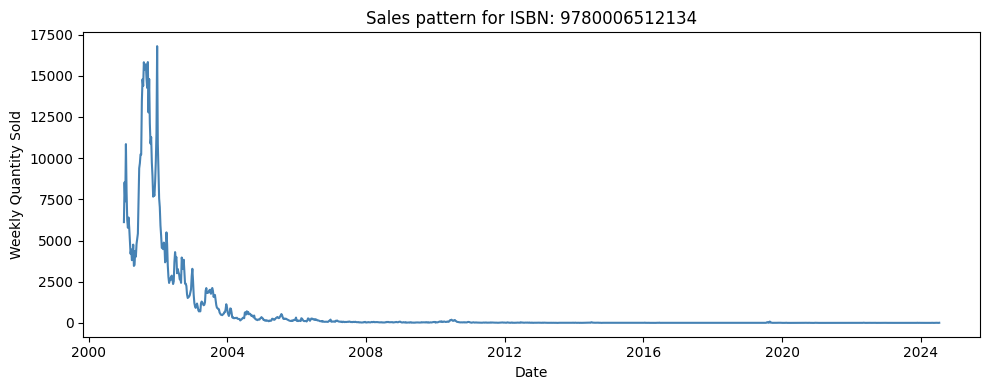

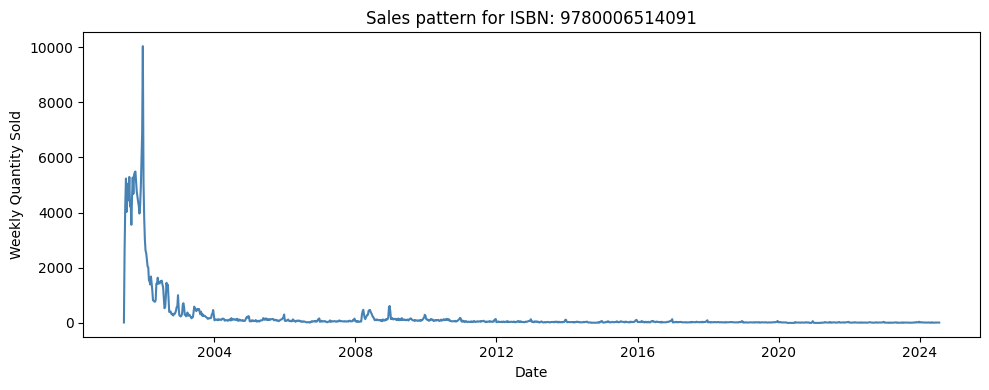

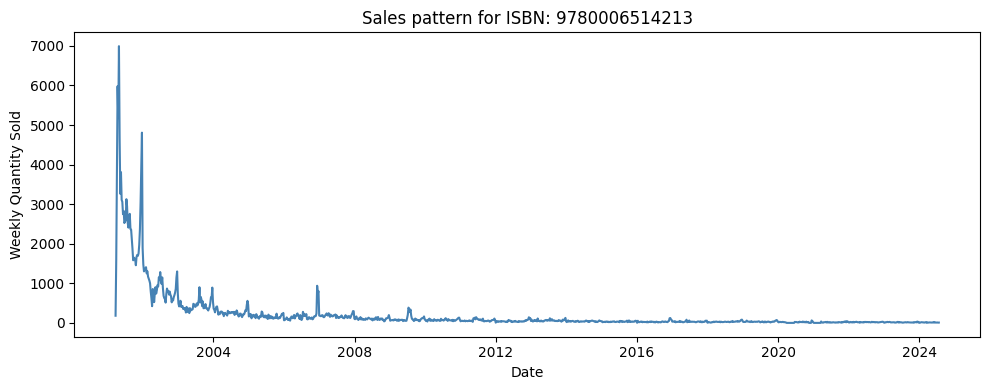

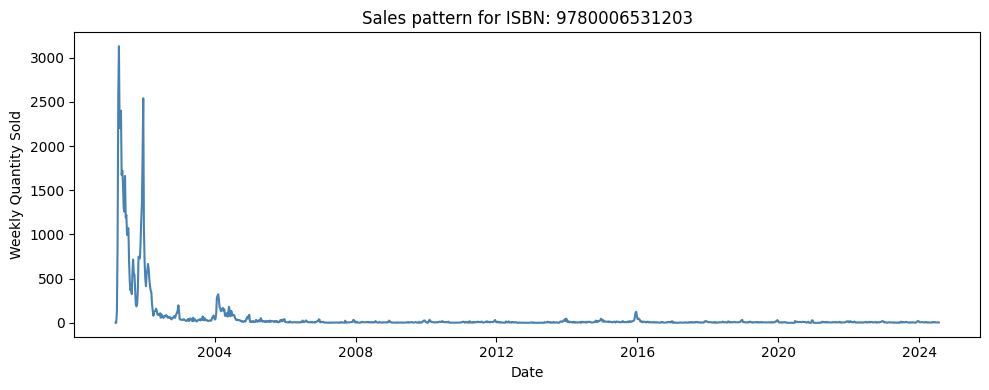

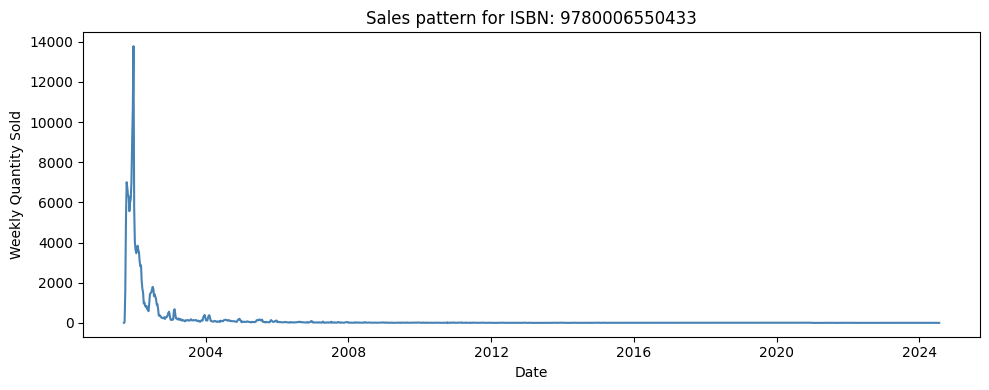

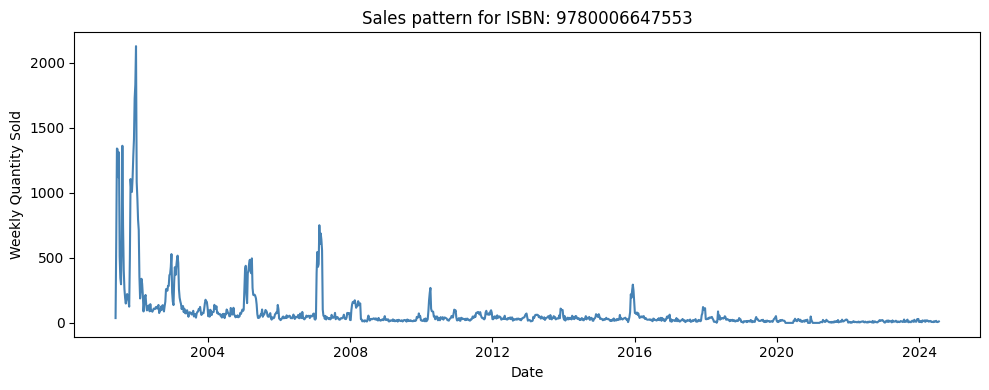

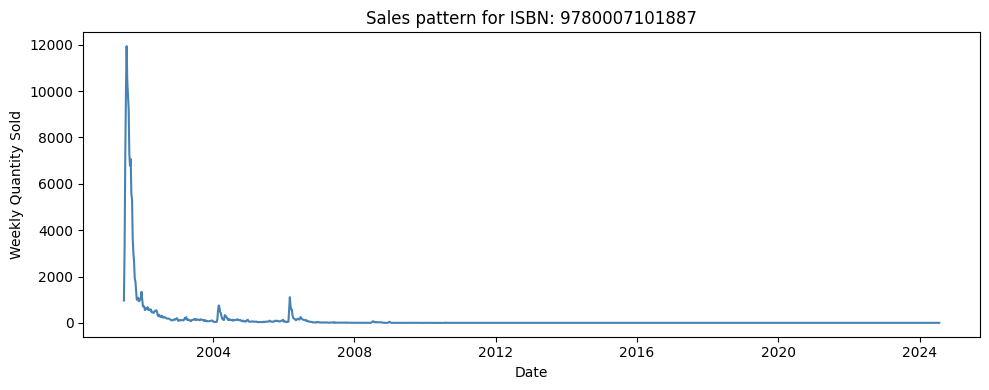

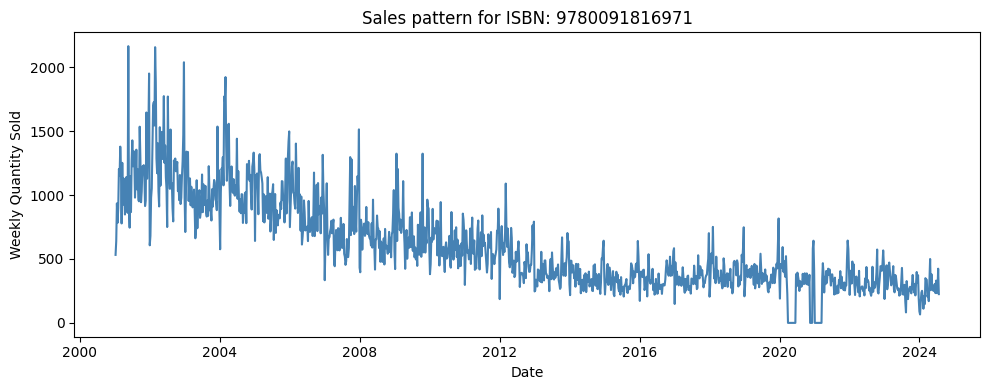

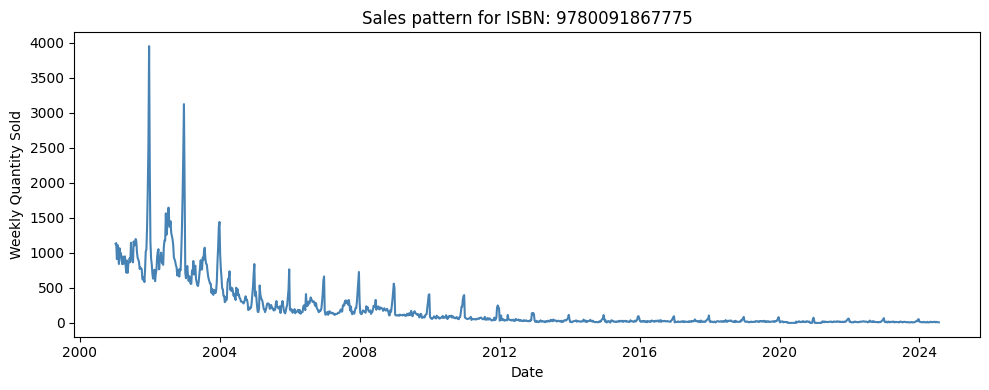

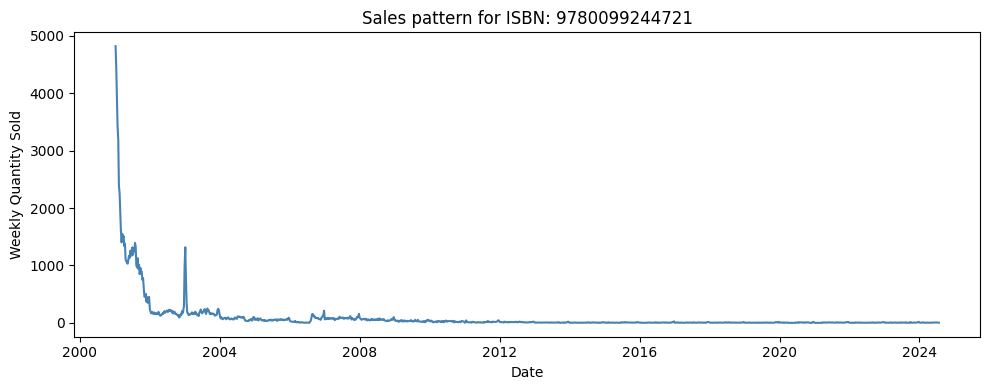

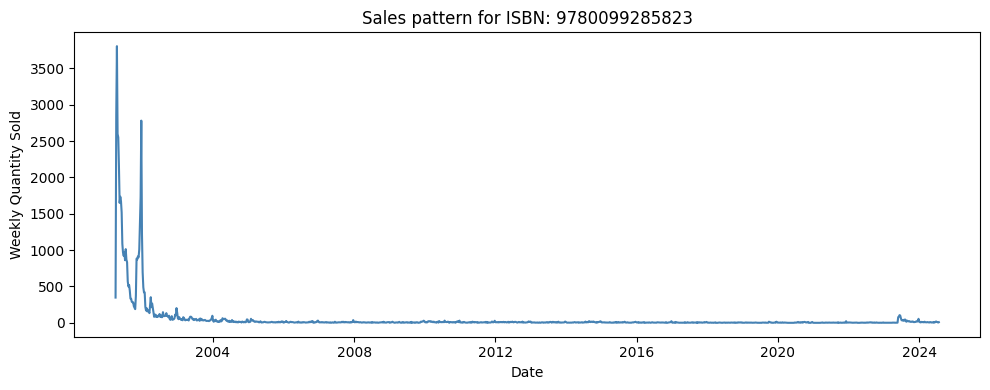

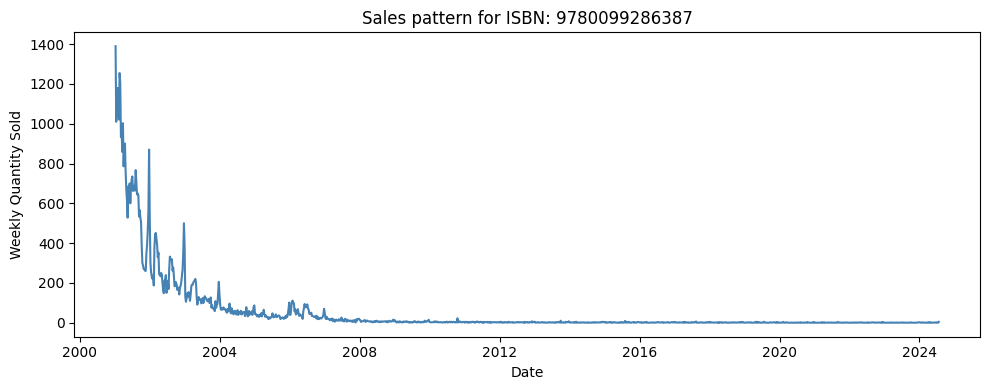

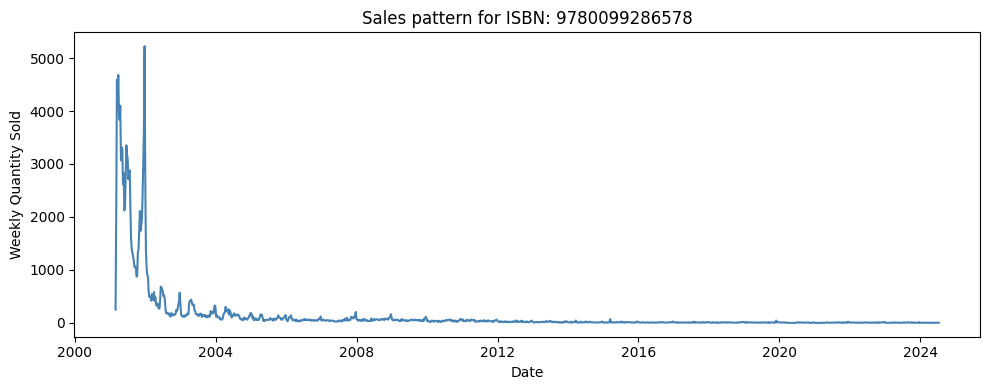

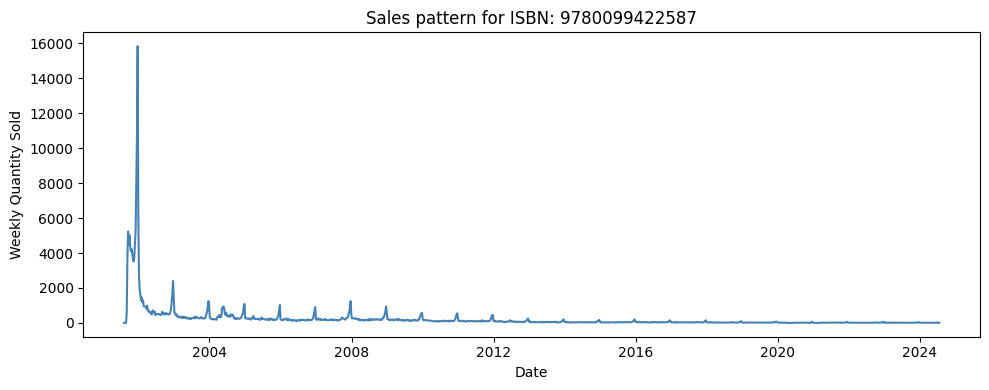

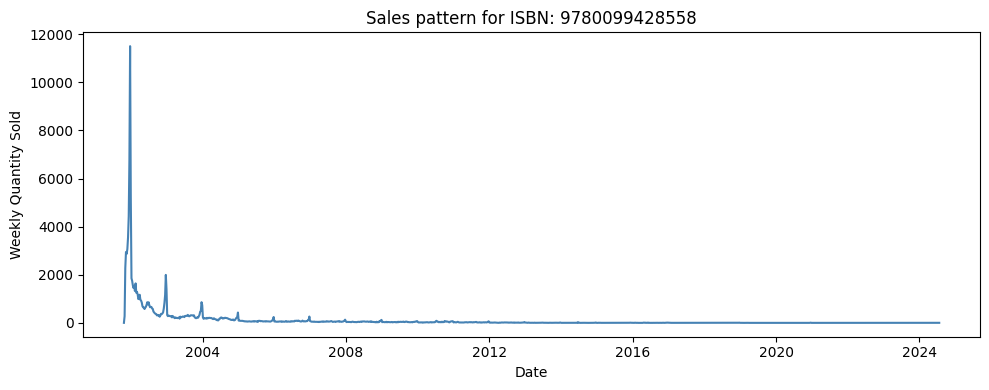

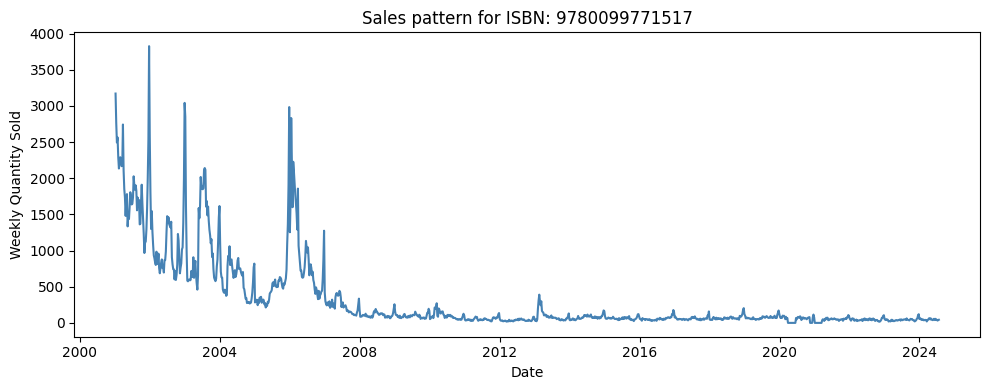

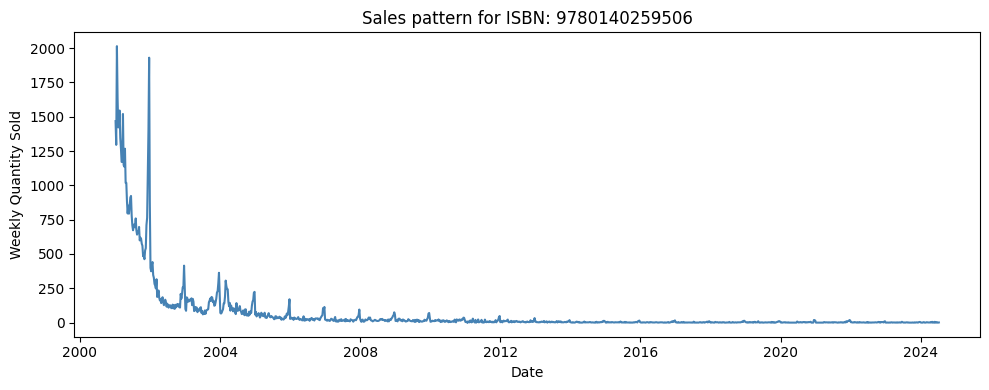

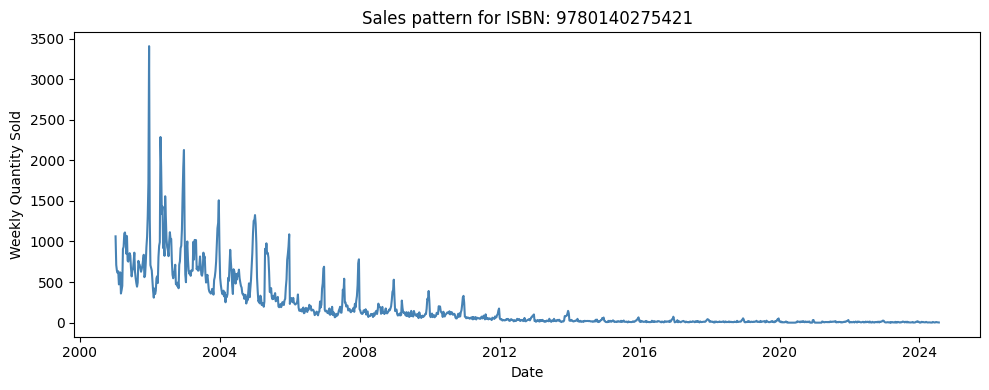

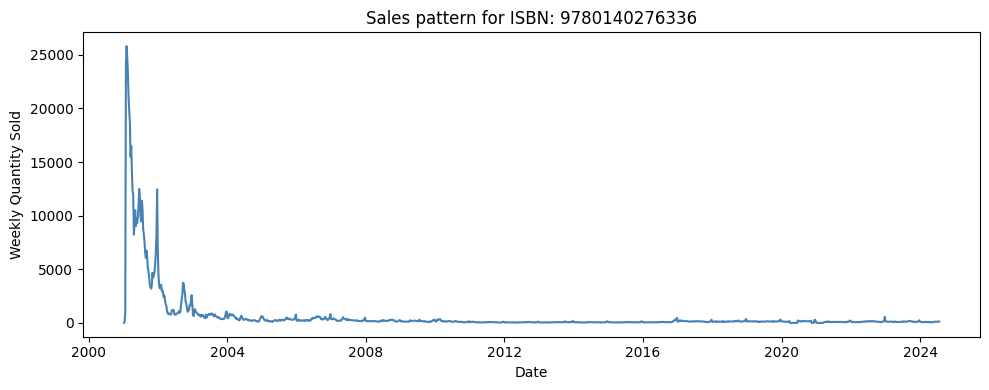

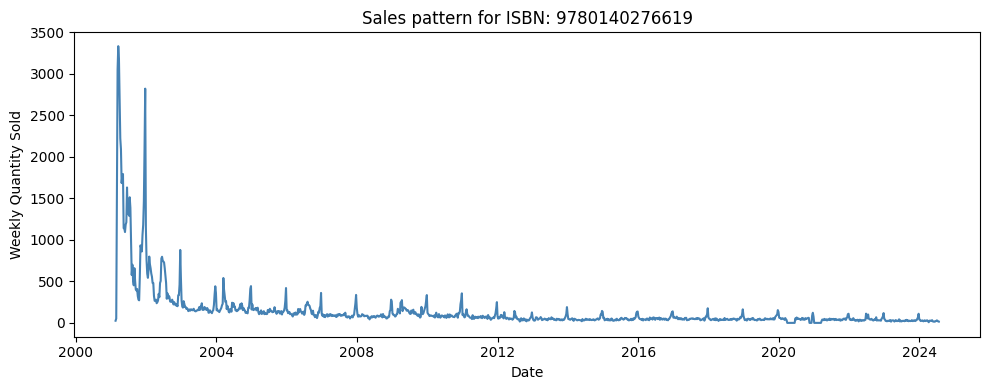

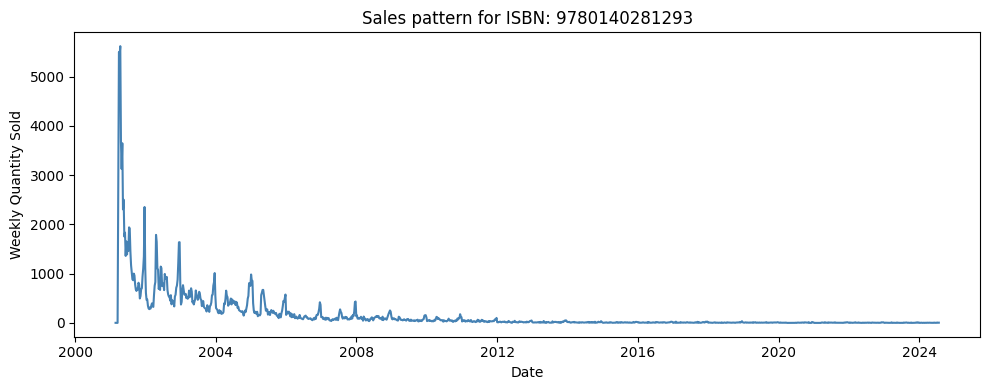

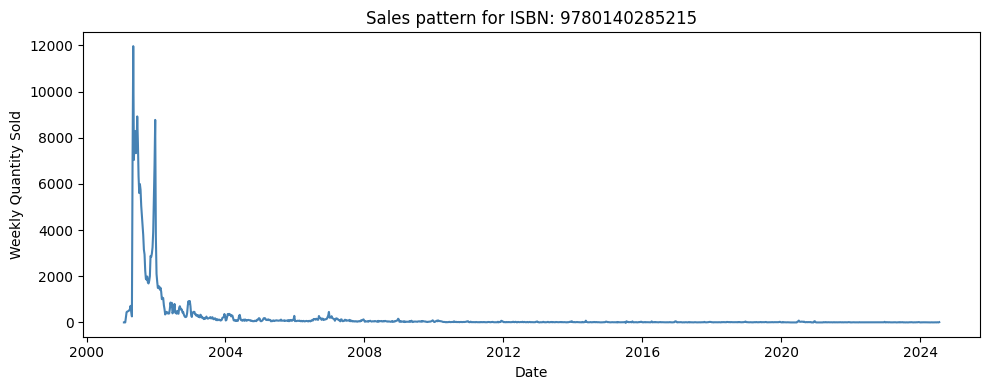

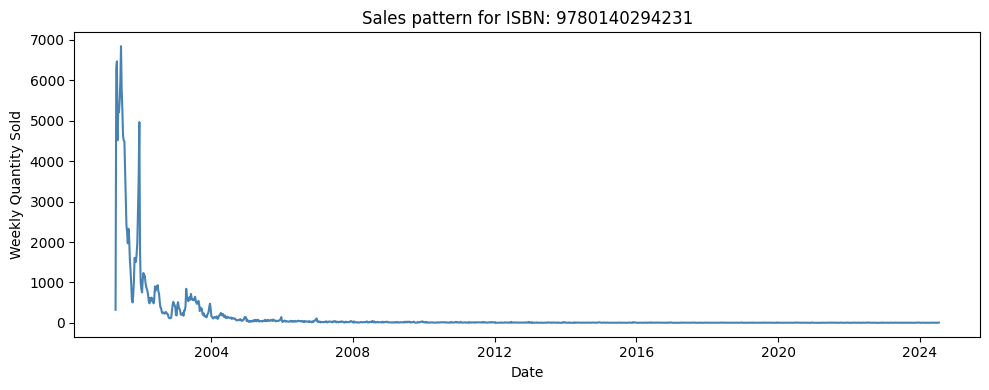

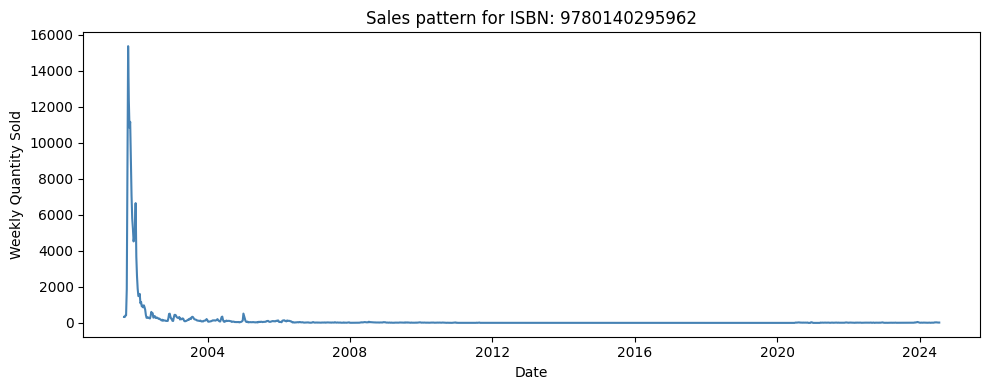

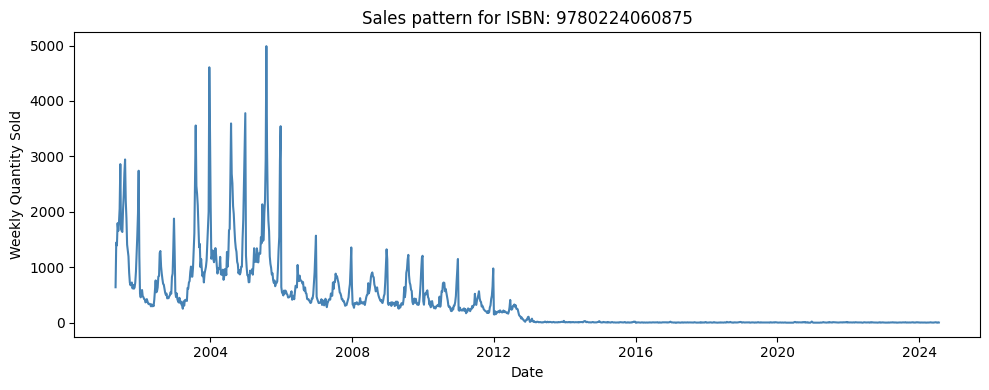

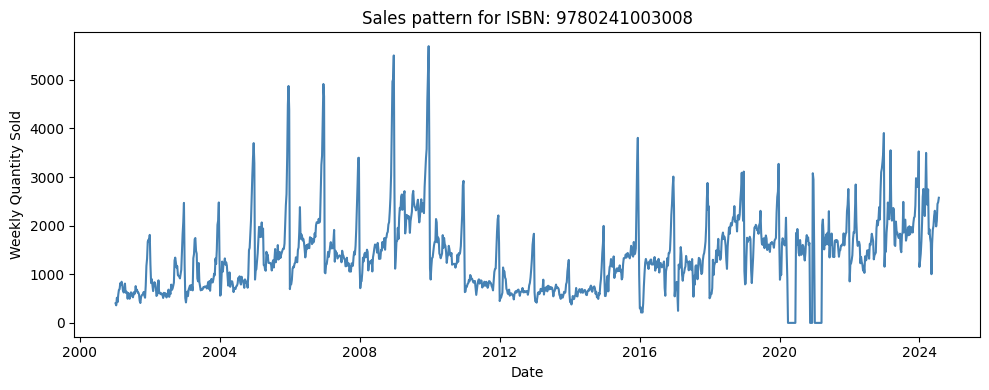

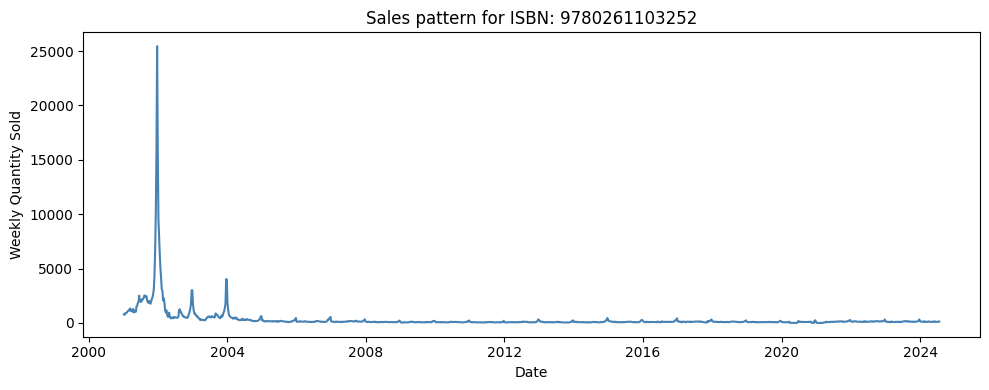

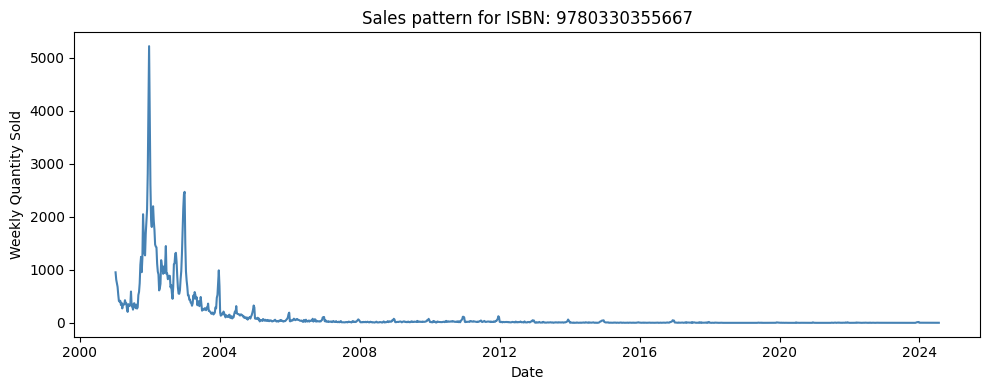

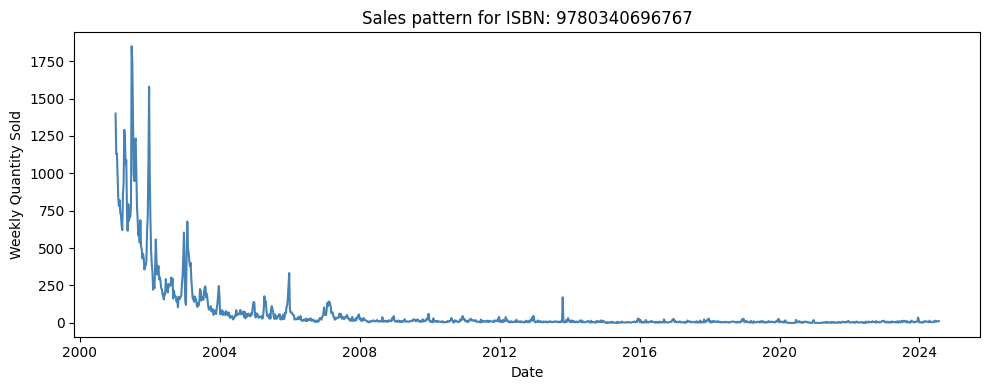

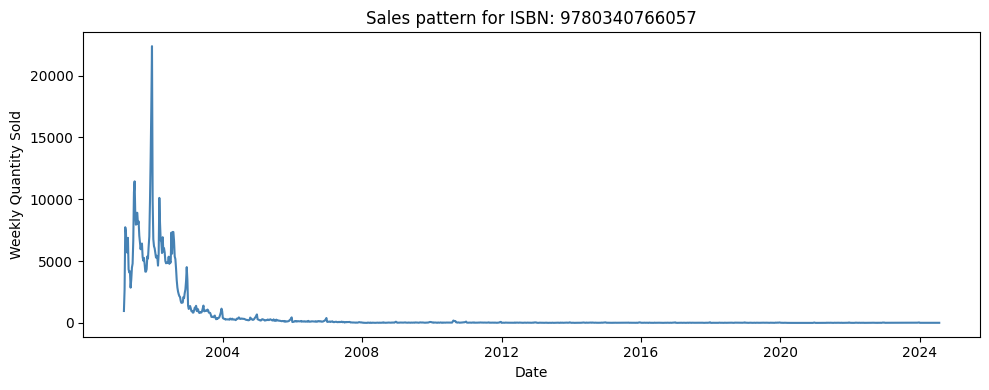

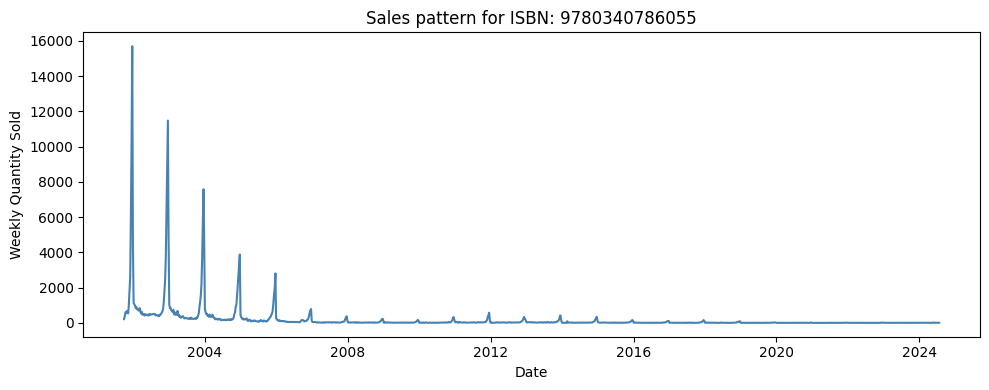

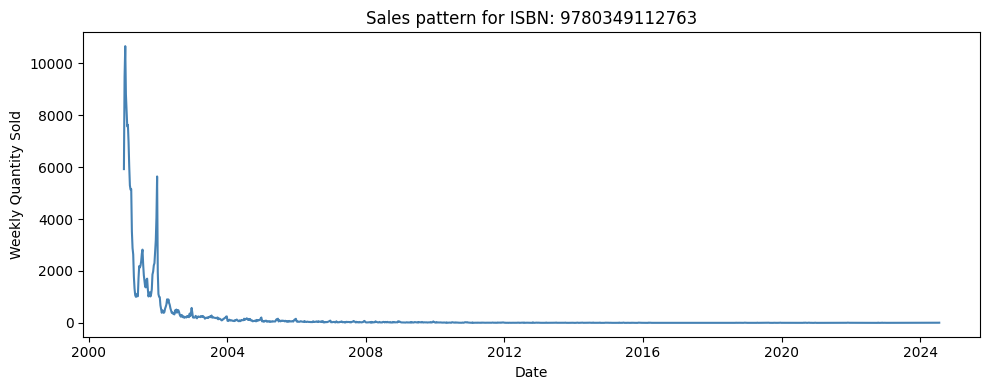

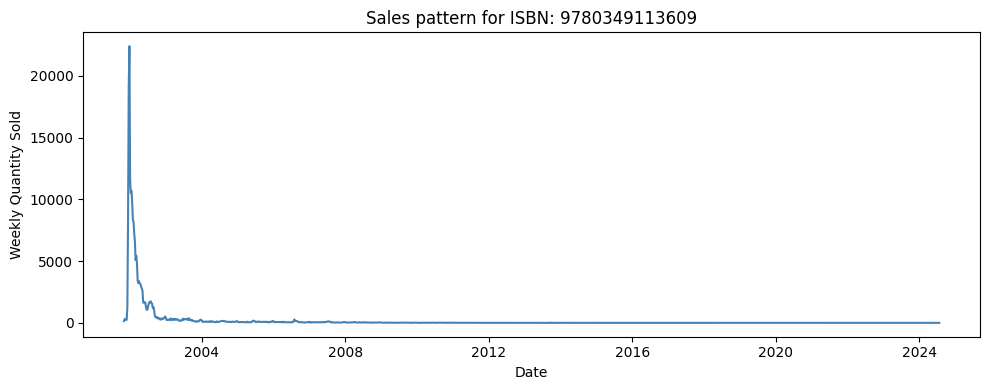

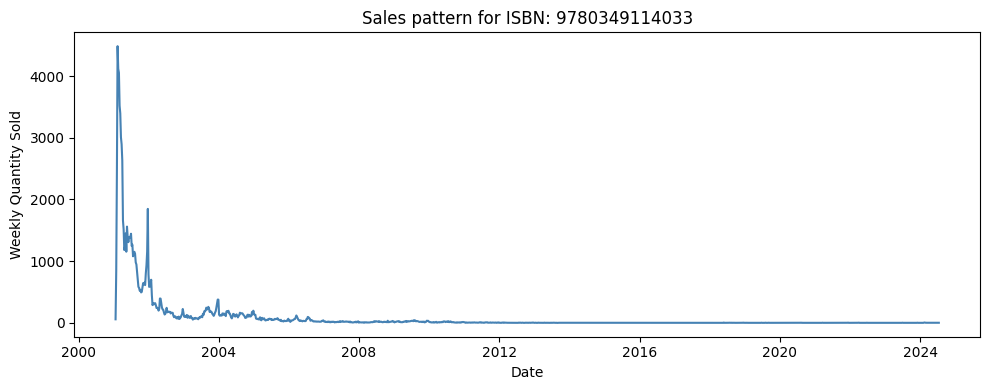

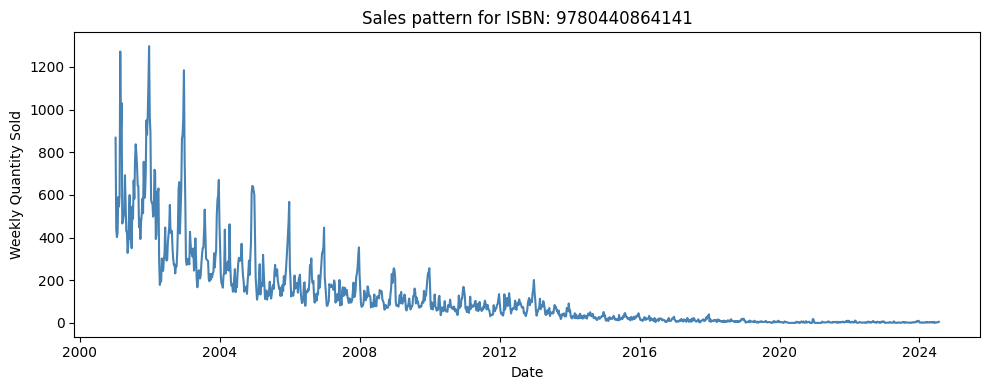

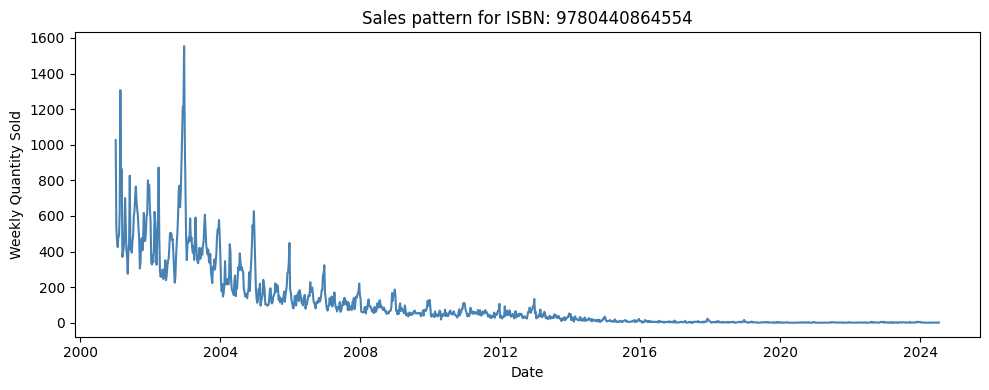

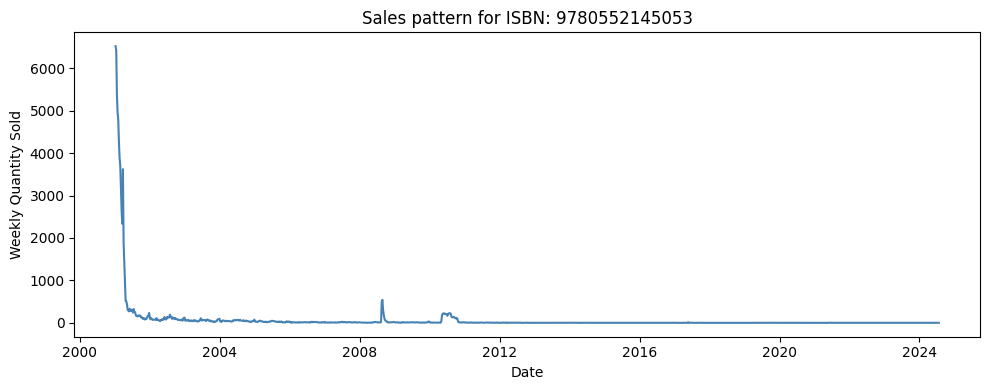

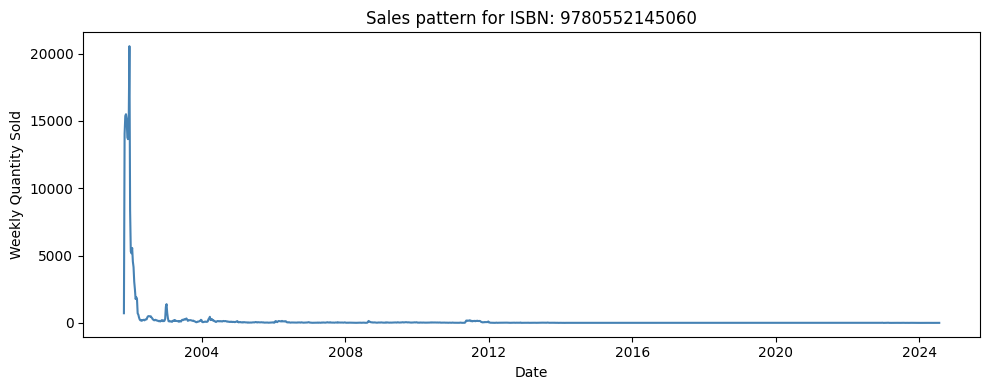

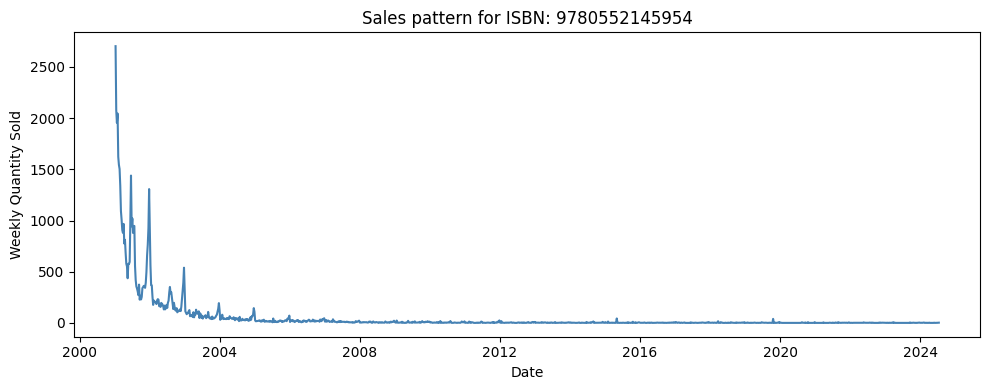

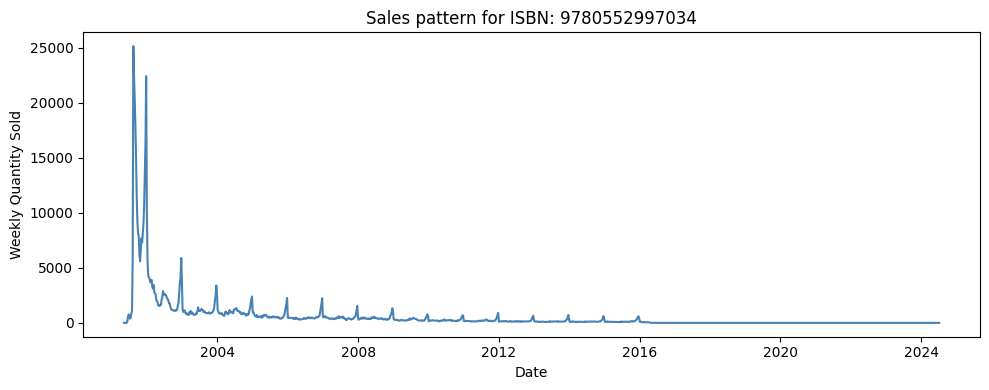

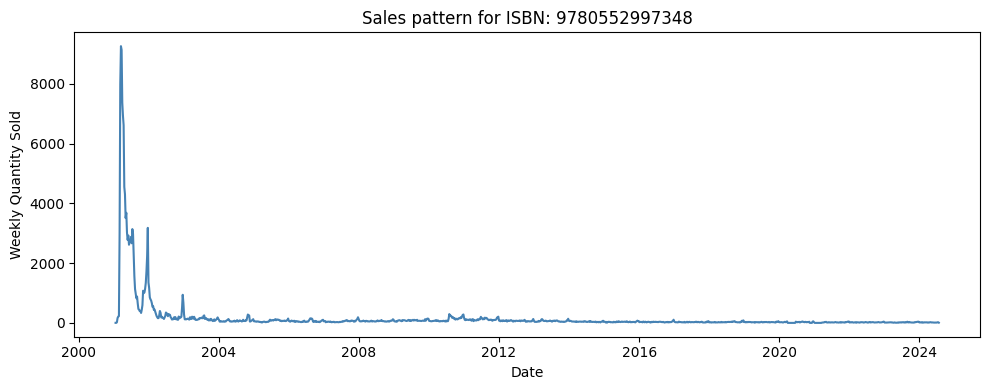

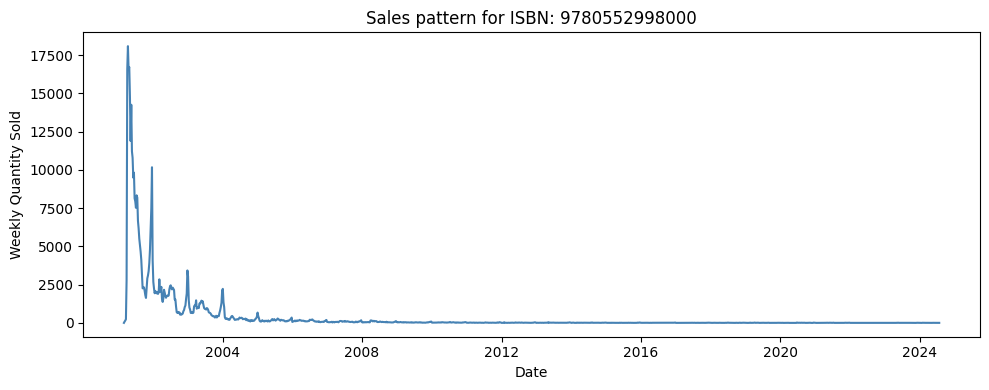

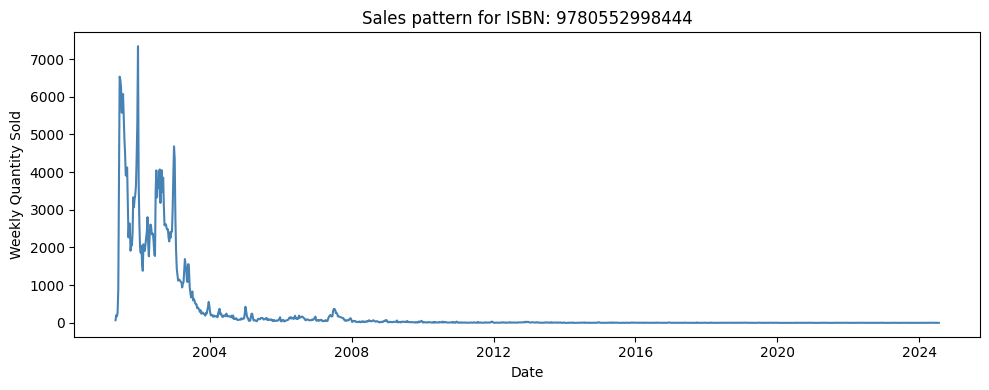

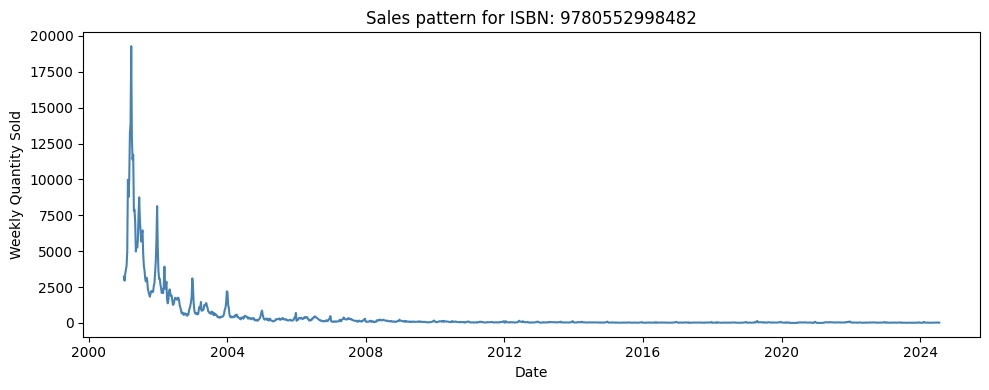

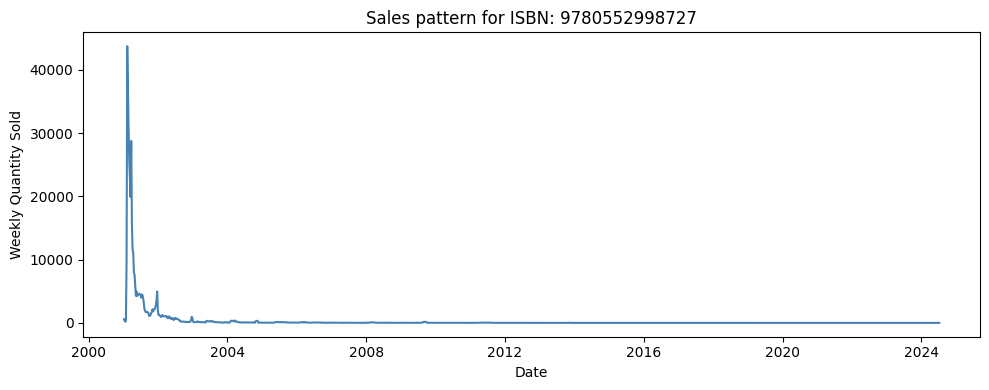

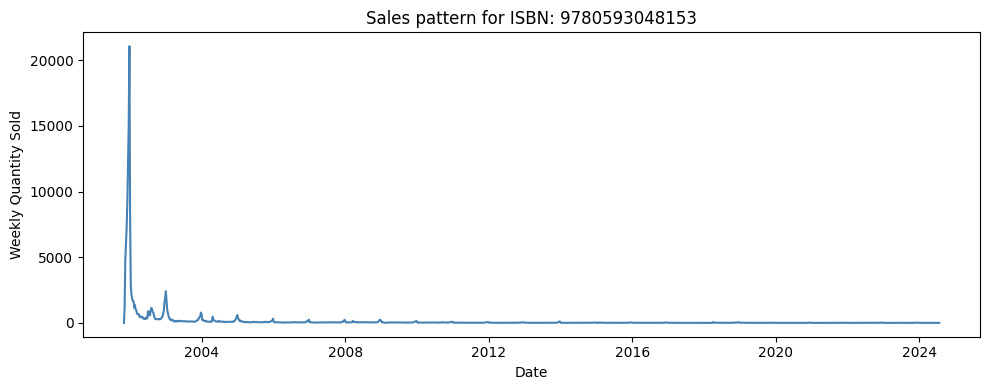

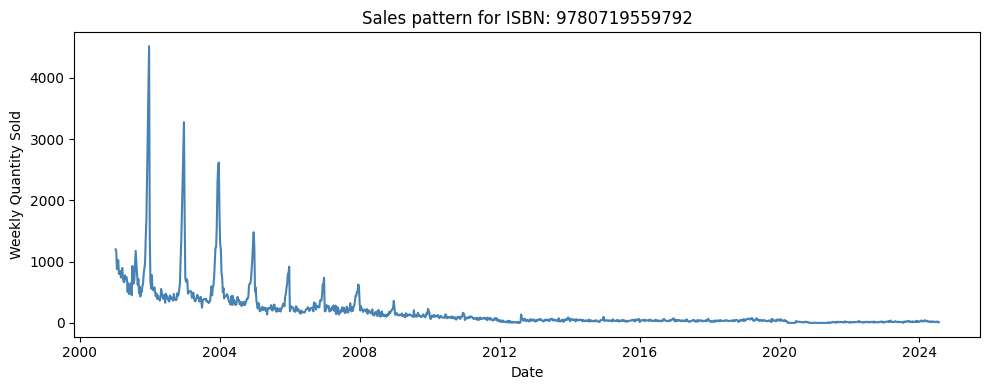

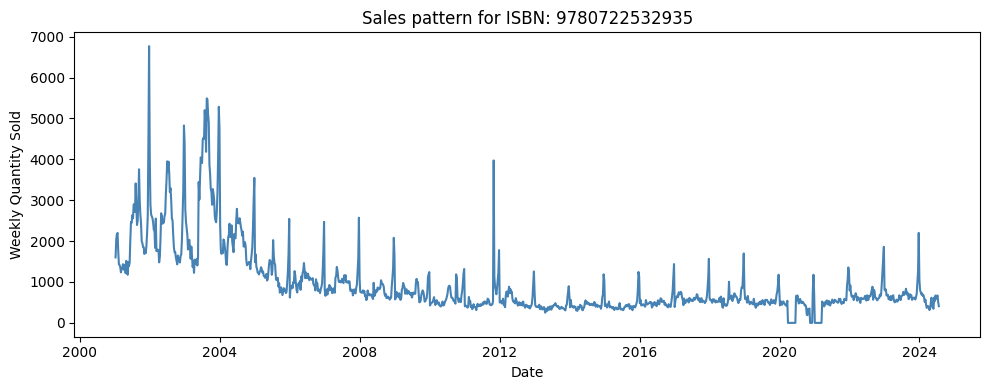

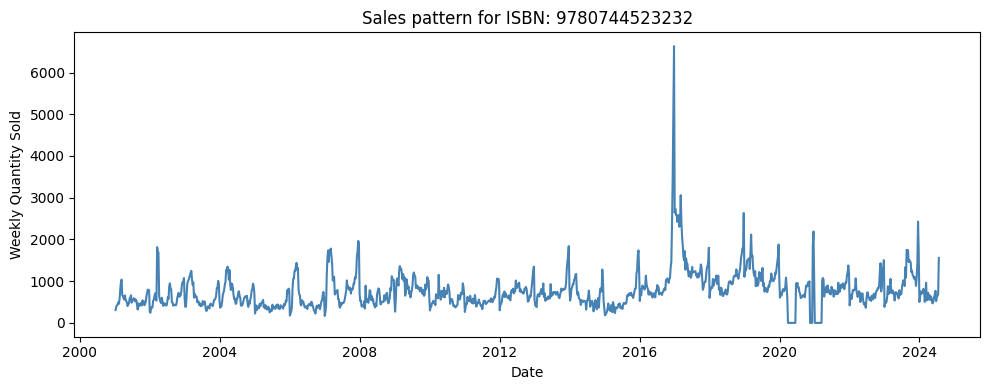

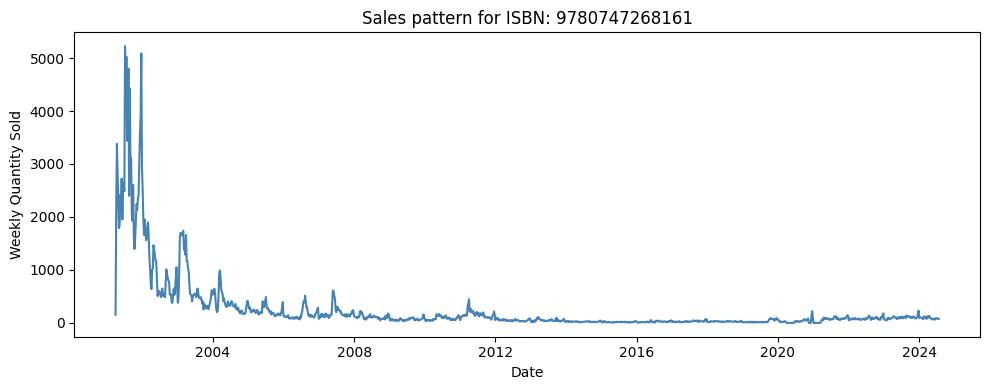

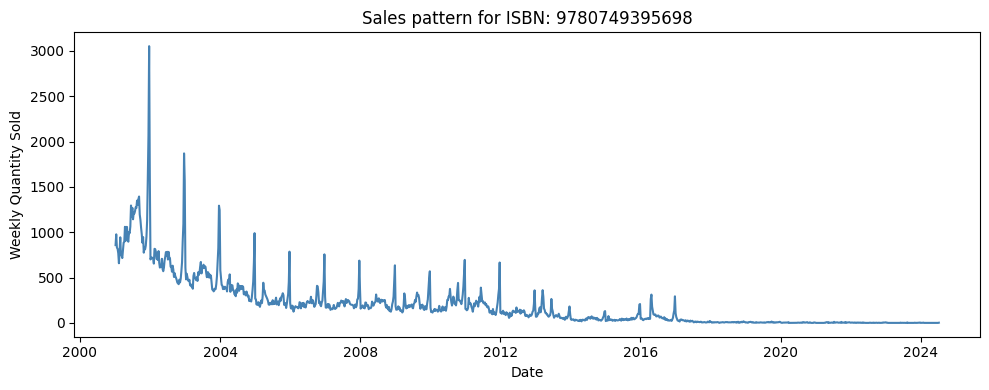

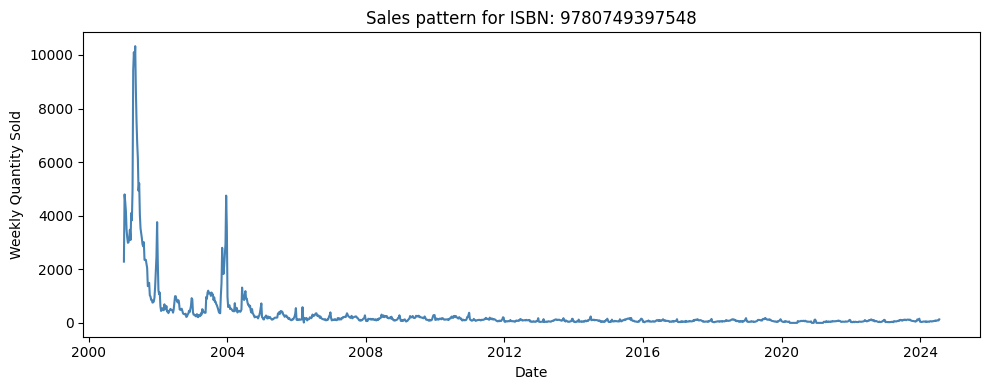

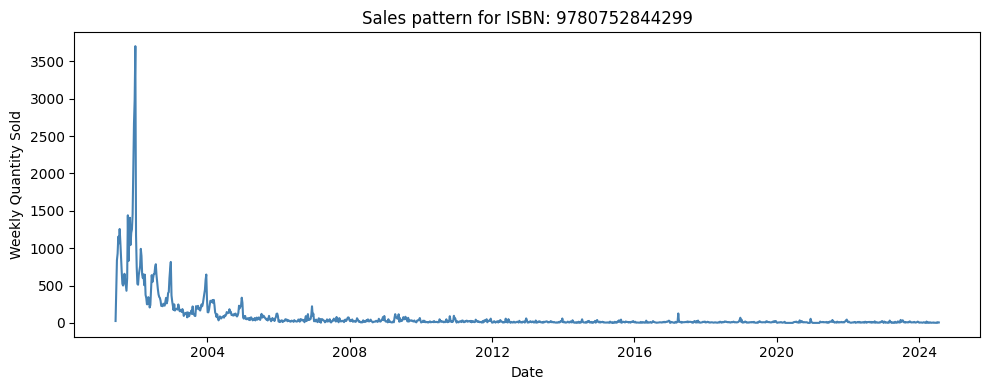

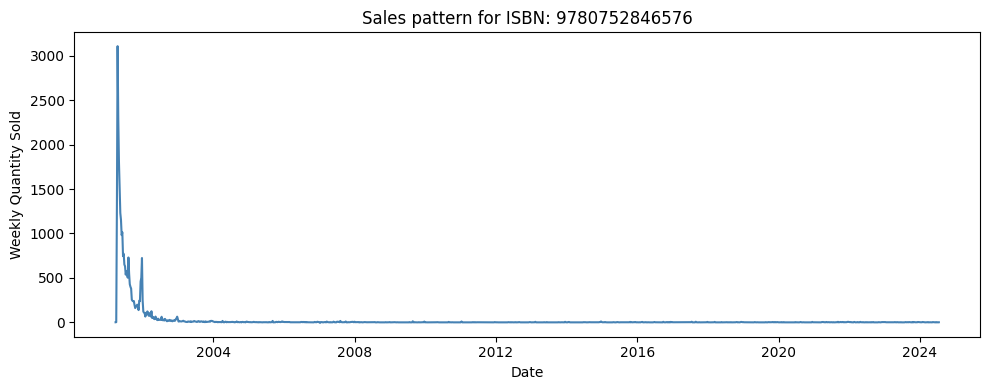

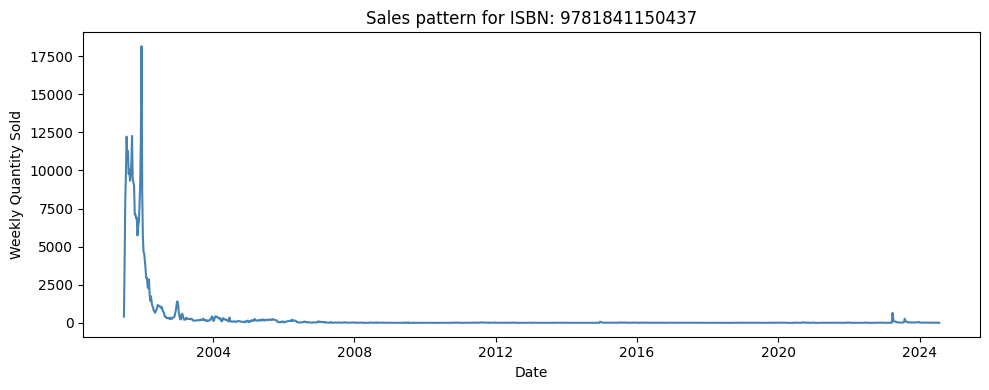

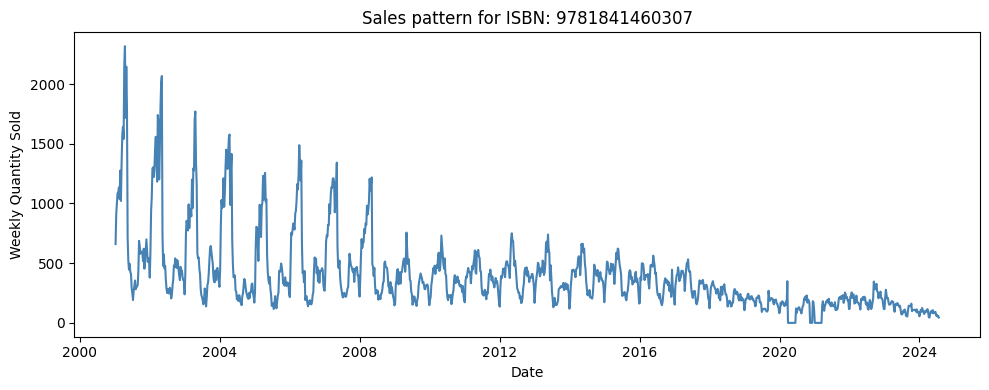

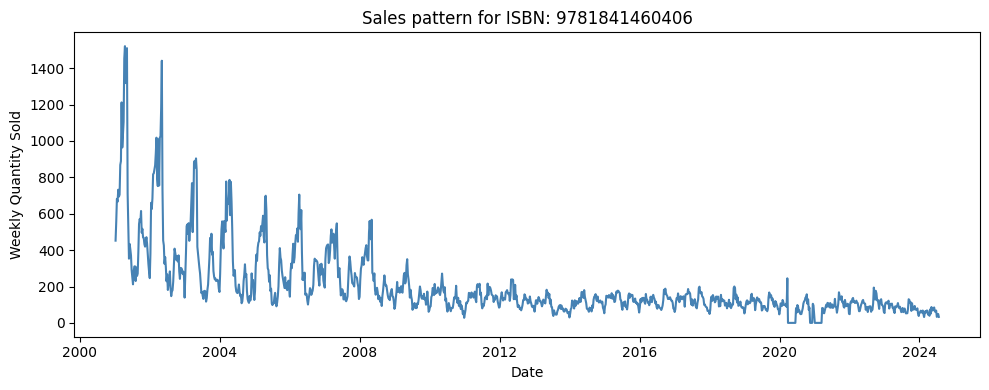

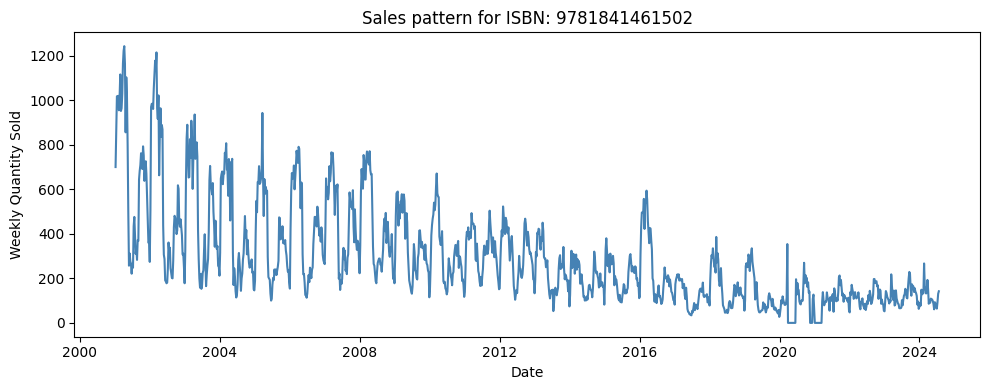

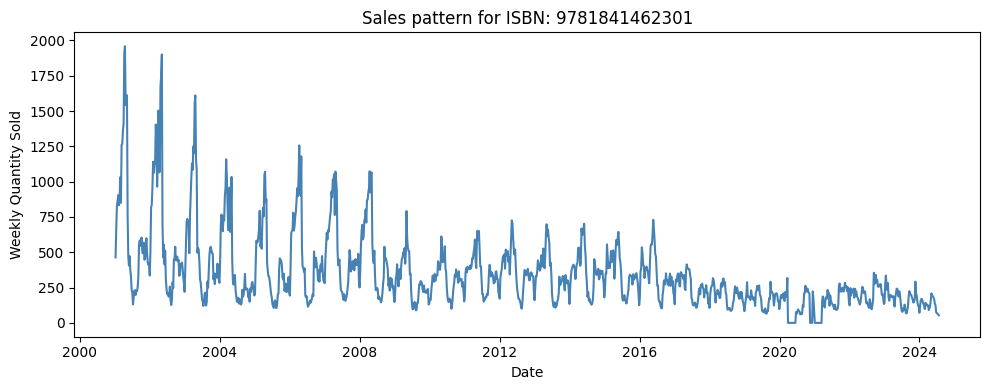

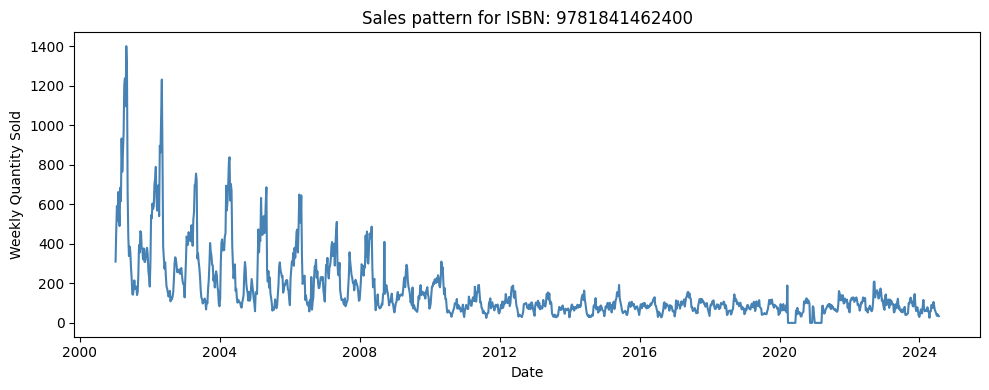

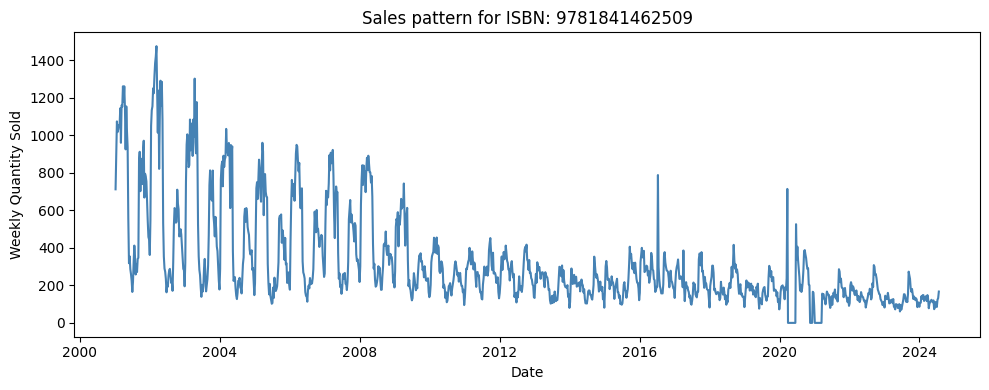

In [ ]:
# Plot sales patterns for those ISBNs
for isbn in isbn_after_cutoff:
    subset = weekly_df[weekly_df['ISBN'] == isbn]
    plt.figure(figsize=(10,4))
    plt.plot(subset['End Date'], subset['Volume'], color='steelblue')
    plt.title(f"Sales pattern for ISBN: {isbn}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Quantity Sold")
    plt.tight_layout()
    plt.show()

> When analysing the sales trends across time, it becomes evident that most books exhibit a strong decline in sales when comparing the first 12 years after publication to the following 12–24 years.

> This behaviour is consistent with typical product life cycle dynamics observed in publishing and other media industries.

In [ ]:
# Find the ISBNs for the two target books
isbn_title_map = merged_df[['ISBN', 'Title']].drop_duplicates()
target_books = ['9780722532935', '9780241003008']
target_isbns = isbn_title_map[isbn_title_map['ISBN'].isin(target_books)]

print("\n=== Target books and their ISBNs ===")
print(target_isbns)


=== Target books and their ISBNs ===
                     ISBN                        Title
End Date                                              
2001-01-06  9780241003008  The Very Hungry Caterpillar
2001-01-06  9780722532935                The Alchemist


In [ ]:
# Filter weekly data for these ISBNs only
target_df = weekly_df[weekly_df['ISBN'].isin(target_isbns['ISBN'])].copy()
target_df.head()

End Date  Volume           ISBN
101932 2001-01-07     402  9780241003008
101933 2001-01-14     361  9780241003008
101934 2001-01-21     517  9780241003008
101935 2001-01-28     426  9780241003008
101936 2001-02-04     580  9780241003008

In [ ]:
# Filter for data from 2012-01-01 onwards
target_df = target_df[target_df['End Date'] >= '2012-01-01']
print("Shape:", target_df.shape)
target_df.head()

Shape: (1312, 3)


End Date  Volume           ISBN
102505 2012-01-01     449  9780241003008
102506 2012-01-08     512  9780241003008
102507 2012-01-15     519  9780241003008
102508 2012-01-22     574  9780241003008
102509 2012-01-29     621  9780241003008

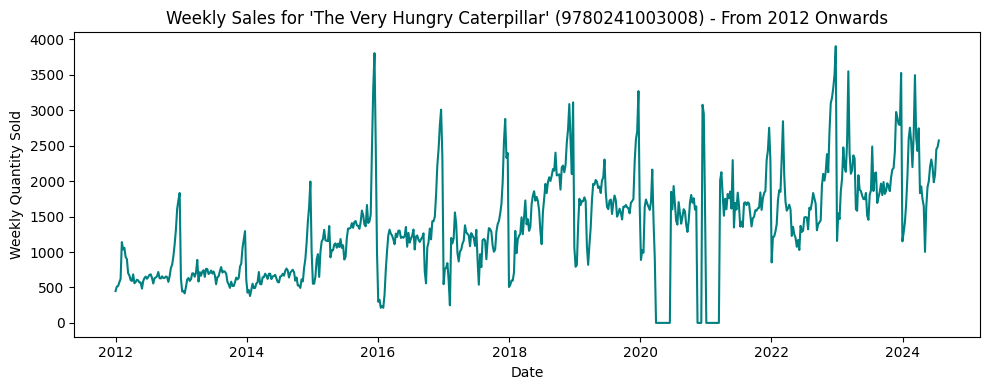

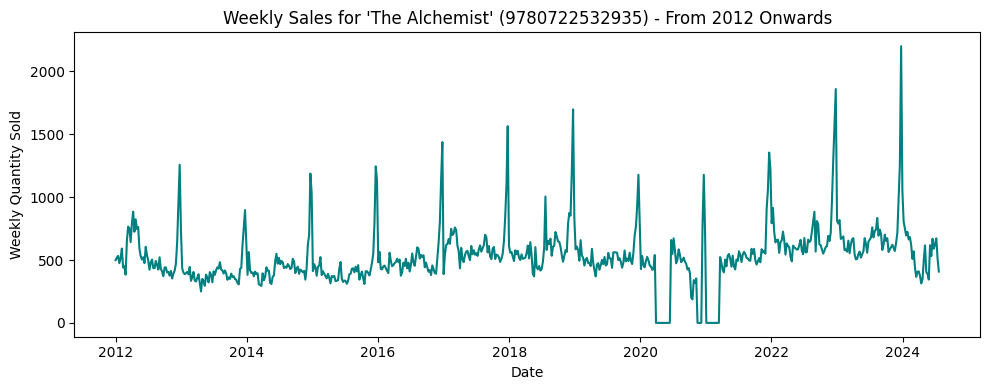

In [ ]:
# --- Plot sales patterns for both books ---
for isbn in target_isbns['ISBN']:
    title = target_isbns.loc[target_isbns['ISBN'] == isbn, 'Title'].values[0]
    subset = target_df[target_df['ISBN'] == isbn]
    plt.figure(figsize=(10,4))
    plt.plot(subset['End Date'], subset['Volume'], color='teal')
    plt.title(f"Weekly Sales for '{title}' ({isbn}) - From 2012 Onwards")
    plt.xlabel("Date")
    plt.ylabel("Weekly Quantity Sold")
    plt.tight_layout()
    plt.show()

##Classical Techniques

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Prepare list of target books (ISBN + Titles)
title_map  = {
    '9780722532935': 'The Alchemist',
    '9780241003008': 'The Very Hungry Caterpillar'
}

In [ ]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1312 entries, 102505 to 261648
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   End Date  1312 non-null   datetime64[ns]
 1   Volume    1312 non-null   int64         
 2   ISBN      1312 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 41.0+ KB


In [ ]:
# Ensure data is weekly and complete for each book
target_df = target_df.groupby('ISBN', group_keys=False).apply(lambda x: x.set_index('End Date').asfreq('W', fill_value=0)).reset_index()
target_df = target_df.rename(columns={'level_0': 'ISBN', 'level_1': 'End Date'})

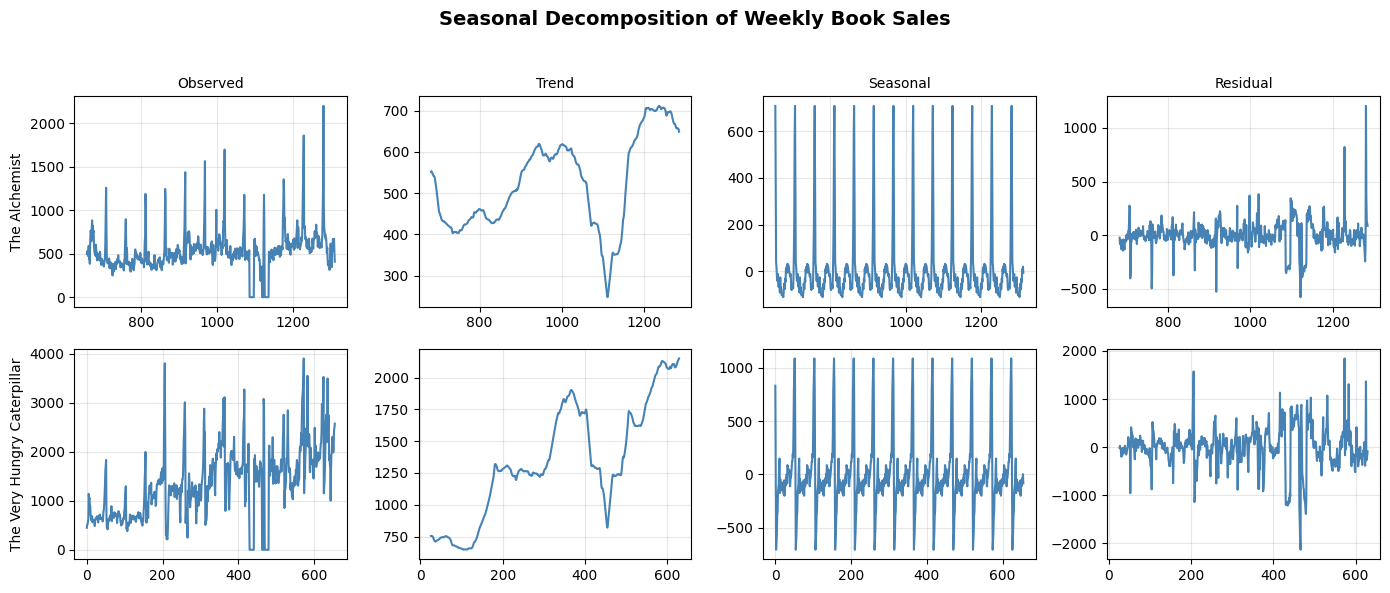

In [ ]:
# Create a single figure with 2 columns for side-by-side decomposition plots
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
fig.suptitle("Seasonal Decomposition of Weekly Book Sales", fontsize=14, fontweight='bold')

for row, (isbn, title) in enumerate(title_map.items()):
    book_df = target_df[target_df['ISBN'] == isbn]
    result = seasonal_decompose(book_df['Volume'], model='additive', period=52)

    components = [result.observed, result.trend, result.seasonal, result.resid]
    comp_titles = ['Observed', 'Trend', 'Seasonal', 'Residual']

    for col, (comp, comp_title) in enumerate(zip(components, comp_titles)):
        axes[row, col].plot(comp, color='steelblue')
        if row == 0:
            axes[row, col].set_title(comp_title, fontsize=10)
        axes[row, col].set_ylabel(title if col == 0 else "")
        axes[row, col].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

>The decomposition analysis successfully isolates the key dynamics of book sales volume:
**Volume** with High volatility in raw sales data. **Trend** shows the long-term, underlying movement. Both books exhibit an overall positive trajectory. **Seasonal** displays a strong, recurrent weekly pattern, indicating consistent sales peaks and troughs within the year.
**Residual** largely centered around zero , but contains significant outliers representing unpredictable, extreme sales events.
Multiplicative seasonality cannot be applied to zero values

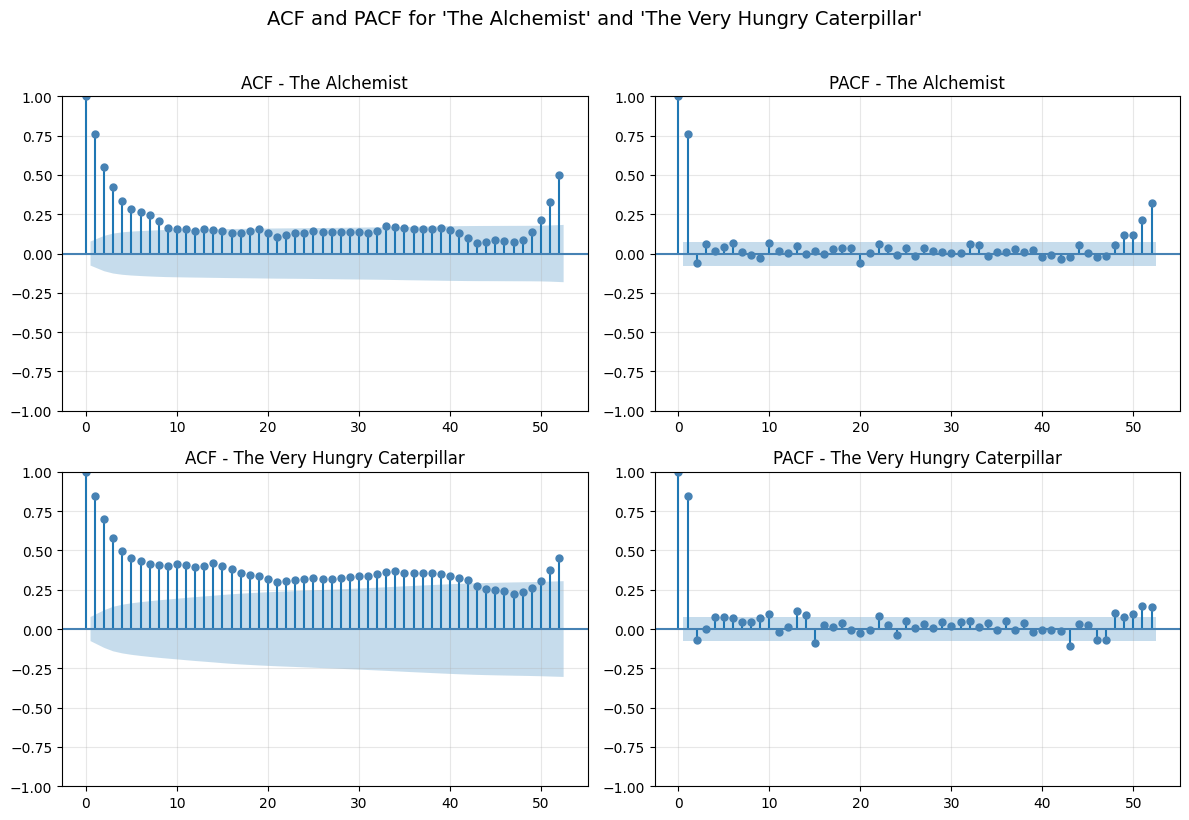

In [ ]:
#ACF and PACF Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("ACF and PACF for 'The Alchemist' and 'The Very Hungry Caterpillar'", fontsize=14, y=1.02)
# Plot loop
for i, (isbn, title) in enumerate(title_map.items()):
    book_df = target_df[target_df['ISBN'] == isbn].set_index('End Date')
    series = book_df['Volume']
    row = i

    # ACF
    plot_acf(series, ax=axes[row, 0], lags=52, color='steelblue', alpha=0.05)
    axes[row, 0].set_title(f"ACF - {title}")
    axes[row, 0].grid(alpha=0.3)

    # PACF
    plot_pacf(series, ax=axes[row, 1], lags=52, color='steelblue', alpha=0.05)
    axes[row, 1].set_title(f"PACF - {title}")
    axes[row, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

> For both books, ACF shows a slow, steady decay and a significant spike at Lag 52. This strongly suggests the data is non-stationary and exhibits strong annual/weekly seasonality. Differencing is necessary. PACF has significant spikes primarily at Lag 1, 2, and 52. This suggests potential non-seasonal AR components and a seasonal SAR component.

In [ ]:
#Stationarity Check (ADF Test)
for isbn, title in title_map.items():
    book_df = target_df[target_df['ISBN'] == isbn]
    adf_result = adfuller(book_df['Volume'])
    print(f"\n=== ADF Test for '{title}' ===")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]}")
    print("→ Stationary" if adf_result[1] < 0.05 else "→ Non-stationary")


=== ADF Test for 'The Alchemist' ===
ADF Statistic: -8.3005
p-value: 4.029390006505253e-13
→ Stationary

=== ADF Test for 'The Very Hungry Caterpillar' ===
ADF Statistic: -3.0331
p-value: 0.031917002549914794
→ Stationary


> The results indicate that both series, despite the strong Trend and Seasonality components observed in the decomposition, are considered stationary according to the ADF test.

###Auto ARIMA model

In [ ]:
forecast_horizon = 32

In [ ]:
def fit_auto_arima(series, title, forecast_horizon=32, stationary=True):
  """
  Fits an Auto ARIMA model on a weekly time series and plots forecast results.
  Returns the fitted model, forecast, confidence intervals, and metrics.
  """
  # Split into training and test sets
  train = series.iloc[:-forecast_horizon]
  test = series.iloc[-forecast_horizon:]

  print(f"\n{'='*25} {title} {'='*25}")
  print(f"Training data: {train.index.min().date()} → {train.index.max().date()}")
  print(f"Forecast horizon: {test.index.min().date()} → {test.index.max().date()}")

  #Model fitting
  AARIMA_model = pm.auto_arima(
    y=train,
    seasonal=True,
    m=52,
    start_p=0, max_p=3, #AR terms
    start_q=0, max_q=3, #MA terms
    start_P=0, max_P=2, #Seasonal AR terms
    start_Q=0, max_Q=2, #Seasonal MA terms
    start_d=0, max_d=2,
    start_D=0, max_D=1, #automatic differencing, one seasonal difference
    max_order=10,
    stationary = True,
    test=None, #No differencieng test needed
    seasonal_test=None, #Skpi seasonal differencing test
    information_criterion= 'aic', stepwise = True,
    method='lbfgs', maxiter=50,
    suppress_warnings=True, error_action='ignore',
    trace=False, with_intercept='auto',
    random_state=42
  )
  print("\n--- Model successfully fitted ---")
  print(f"Best model: {AARIMA_model.order} x {AARIMA_model.seasonal_order}")
  print(f"AIC: {AARIMA_model.aic():.2f}")

  return AARIMA_model

In [ ]:

models = {}

for isbn, title in title_map.items():
    book_df = target_df[target_df['ISBN'] == isbn].set_index('End Date').sort_index()
    series = book_df['Volume']
    models[title] = fit_auto_arima(series, title, forecast_horizon=32, stationary=True)



========================= The Alchemist =========================
Training data: 2012-01-01 → 2023-12-10
Forecast horizon: 2023-12-17 → 2024-07-21

--- Model successfully fitted ---
Best model: (1, 0, 2) x (2, 0, 0, 52)
AIC: 7642.47

========================= The Very Hungry Caterpillar =========================
Training data: 2012-01-01 → 2023-12-10
Forecast horizon: 2023-12-17 → 2024-07-21

--- Model successfully fitted ---
Best model: (1, 0, 0) x (2, 0, 1, 52)
AIC: 9016.50


In [ ]:

print(f"\n{'='*26} The Alchemist best auto ARIMA model {'='*26}")
print(models['The Alchemist'].summary())

print(f"\n{'='*21} The Very Hungry Caterpillar best auto ARIMA model {'='*21}")
print(models['The Very Hungry Caterpillar'].summary())



========================== The Alchemist best auto ARIMA model ==========================
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  624
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 52)   Log Likelihood               -3814.233
Date:                             Sat, 01 Nov 2025   AIC                           7642.465
Time:                                     09:08:35   BIC                           7673.519
Sample:                                 01-01-2012   HQIC                          7654.533
                                      - 12-10-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     1

> 'The Alchemist' book chosen model, SARIMAX(1, 0, 2)x(2, 0, [], 52), achieves an excellent fit, reflected by its low AIC of 7642.465. All non-seasonal (AR(1), MA(1), MA(2)) and seasonal (AR.S.L52, AR.S.L104) parameters are highly statistically significant, indicating a robust structure. Residual analysis is mostly successful, with the Ljung-Box test confirming the residuals are white noise. However, diagnostics reveal that the residuals violate assumptions of normality and homoskedasticity, suggesting outliers in the observations.

>'The Very Hungry Caterpillar' book final model is SARIMAX(1, 0, 0)x(2, 0, [1], 52), which provides a less efficient fit, indicated by a high AIC of 9016.303. A key issue is the non-significance of the seasonal MA term (ma.S.L52, $P=0.381$), suggesting the model is over-parameterized and requires refinement. Like the first model, it successfully converts the series into white noise. However, its residuals also exhibit significant problems with non-normality and heteroskedasticity.


==================== Residuals for The Alchemist ====================
Mean: 0.908 | Std: 108.721
→ Ideally residuals should have mean ≈ 0 and show no autocorrelation.


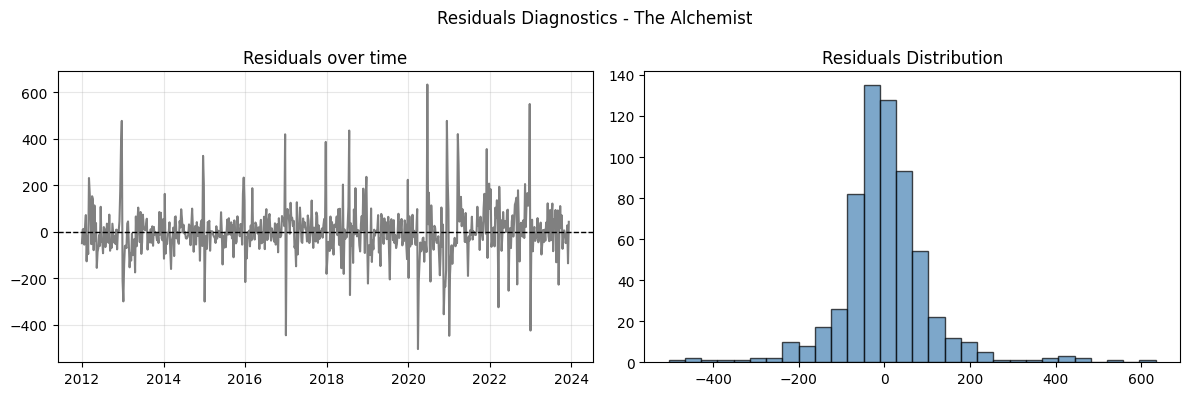


==================== Residuals for The Very Hungry Caterpillar ====================
Mean: 5.647 | Std: 327.824
→ Ideally residuals should have mean ≈ 0 and show no autocorrelation.


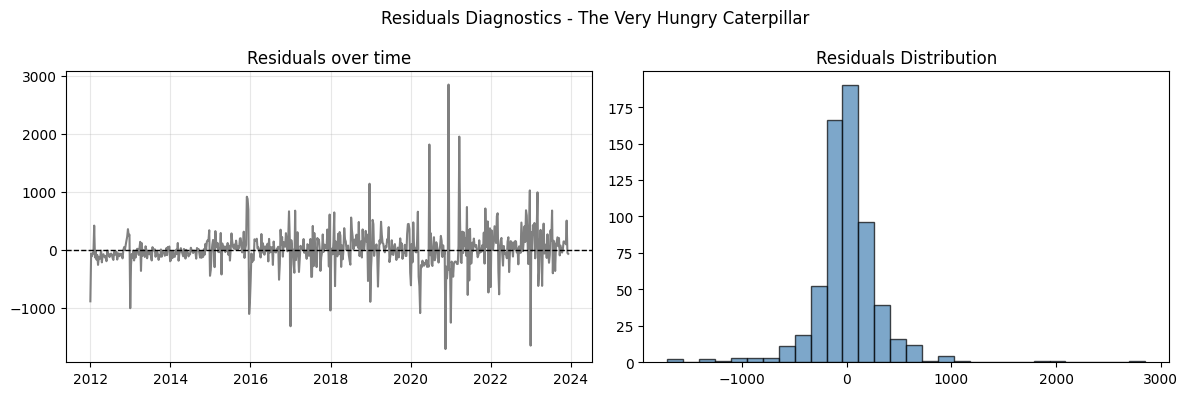

In [ ]:

residuals_dict = {}
for isbn, title in title_map.items():
    model = models[title]
    book_df = target_df[target_df['ISBN'] == isbn].set_index('End Date').sort_index()
    series = book_df['Volume']
    train = series.iloc[:-forecast_horizon]

    # Extract residuals from model
    residuals = model.resid()
    residuals_dict[title] = residuals

    print(f"\n{'='*20} Residuals for {title} {'='*20}")
    print(f"Mean: {residuals.mean():.3f} | Std: {residuals.std():.3f}")
    print("→ Ideally residuals should have mean ≈ 0 and show no autocorrelation.")

    #plotting
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f"Residuals Diagnostics - {title}", fontsize=12)

    # Residuals over time
    axes[0].plot(residuals, color='gray')
    axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0].set_title("Residuals over time")
    axes[0].grid(alpha=0.3)

    # Histogram
    axes[1].hist(residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].set_title("Residuals Distribution")
    plt.tight_layout()
    plt.show()


>The Alchemist model residuals show an ideal Mean ($0.918$) close to zero, which indicates the model is unbiased—it neither systematically over- nor underestimates sales volume. The Standard Deviation ($108.721$) is high relative to the mean, reflecting the data's volatility.

>The Very Hungry Caterpillar model also achieves an unbiased Mean ($15.570$) close to zero. However, the Standard Deviation ($327.002$) is substantially higher than that of 'The Alchemist'. This signifies that the model was less effective at capturing the variability in this particular series.

In [ ]:
def forecast_and_evaluate(models, target_df, title_map, forecast_horizon=32):
    """
    Uses the fitted Auto ARIMA models to forecast the final 32 weeks
    and plots predictions vs actuals with confidence intervals.
    Returns a dictionary with forecasts, MAE, and MAPE for each book.
    """
    results = {}

    for isbn, title in title_map.items():
        print(f"\n{'='*25} Forecasting for {title} {'='*25}")

        model = models[title]
        book_df = target_df[target_df['ISBN'] == isbn].set_index('End Date').sort_index()
        series = book_df['Volume']

        # Split into train/test
        train = series.iloc[:-forecast_horizon]
        test = series.iloc[-forecast_horizon:]

        # Forecast
        forecast, conf_int = model.predict(n_periods=forecast_horizon, return_conf_int=True)
        forecast_index = test.index

        # Plot forecast vs actual
        plt.figure(figsize=(10,5))
        plt.plot(train.index, train, label='Train', color='lightgrey')
        plt.plot(test.index, test, label='Actual', color='steelblue')
        plt.plot(forecast_index, forecast, label='Forecast', color='darkorange')
        plt.fill_between(forecast_index, conf_int[:,0], conf_int[:,1], color='orange', alpha=0.2)
        plt.title(f"Auto ARIMA Forecast (32 Weeks) - {title}")
        plt.xlabel("Date")
        plt.ylabel("Weekly Sales (Volume)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Metrics
        mae = mean_absolute_error(test, forecast)
        mape = mean_absolute_percentage_error(test, forecast)

        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape*100:.2f}%")

        results[title] = {
            "forecast": forecast,
            "conf_int": conf_int,
            "mae": mae,
            "mape": mape
        }

    return results


========================= Forecasting for The Alchemist =========================


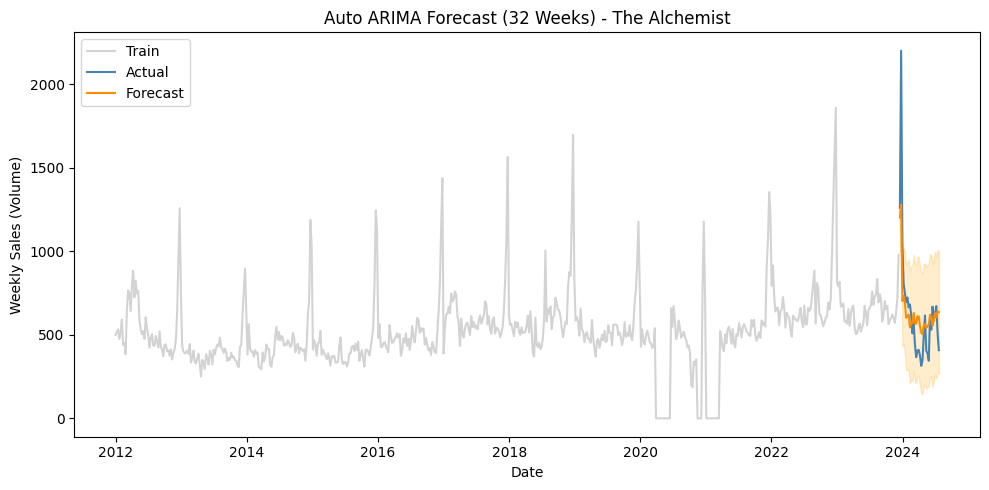

MAE: 141.83
MAPE: 25.18%

========================= Forecasting for The Very Hungry Caterpillar =========================


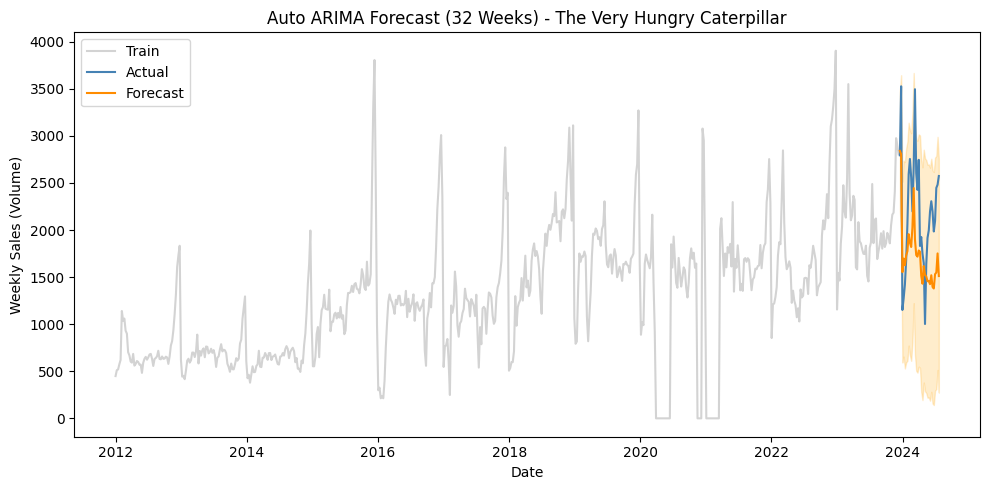

MAE: 550.92
MAPE: 24.79%


In [ ]:
forecast_results = forecast_and_evaluate(models, target_df, title_map, forecast_horizon=32)

> Both Auto ARIMA models capture the overall sales trends and seasonality patterns reasonably well.
For The Alchemist, the model fits the data fairly accurately, although it slightly underestimates recent peaks.
For The Very Hungry Caterpillar, the forecast follows the general direction of the series but struggles with sudden fluctuations and higher volatility.
Overall, the models provide a decent fit, reflecting the main temporal structure of sales while showing some limitations in capturing short-term variations.

## Machine learning and deep learning techniques

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [ ]:
#Prepering data
forecast_horizon = 32
window_length = 12  # number of previous weeks used as features

data_ml = {}

for isbn, title in title_map.items():
    print(f"\n{'='*25} Preparing data for {title} {'='*25}")

    # Extract time series
    book_df = target_df[target_df['ISBN'] == isbn].set_index('End Date').sort_index()
    series = book_df['Volume']
    series = series[series.index >= '2012-01-01']  # focus on 2012+

    # Create lag features
    df = pd.DataFrame({'y': series})
    for lag in range(1, window_length + 1):
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # Drop initial NaN rows
    df = df.dropna().copy()

    # Split train/test (last 32 weeks = test)
    train = df.iloc[:-forecast_horizon]
    test = df.iloc[-forecast_horizon:]

    # Separate features and target
    X_train, y_train = train.drop('y', axis=1), train['y']
    X_test, y_test = test.drop('y', axis=1), test['y']

    # Save all in dictionary
    data_ml[title] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

    print(f"Training shape: {X_train.shape} | Test shape: {X_test.shape}")
    print(f"Train period: {train.index.min().date()} → {train.index.max().date()}")
    print(f"Test period: {test.index.min().date()} → {test.index.max().date()}")


========================= Preparing data for The Alchemist =========================
Training shape: (612, 12) | Test shape: (32, 12)
Train period: 2012-03-25 → 2023-12-10
Test period: 2023-12-17 → 2024-07-21

========================= Preparing data for The Very Hungry Caterpillar =========================
Training shape: (612, 12) | Test shape: (32, 12)
Train period: 2012-03-25 → 2023-12-10
Test period: 2023-12-17 → 2024-07-21


###XGBoost Model


========================= Training XGBoost for The Alchemist =========================
 Model trained for The Alchemist
MAE: 1197.99
MAPE: 50.69%


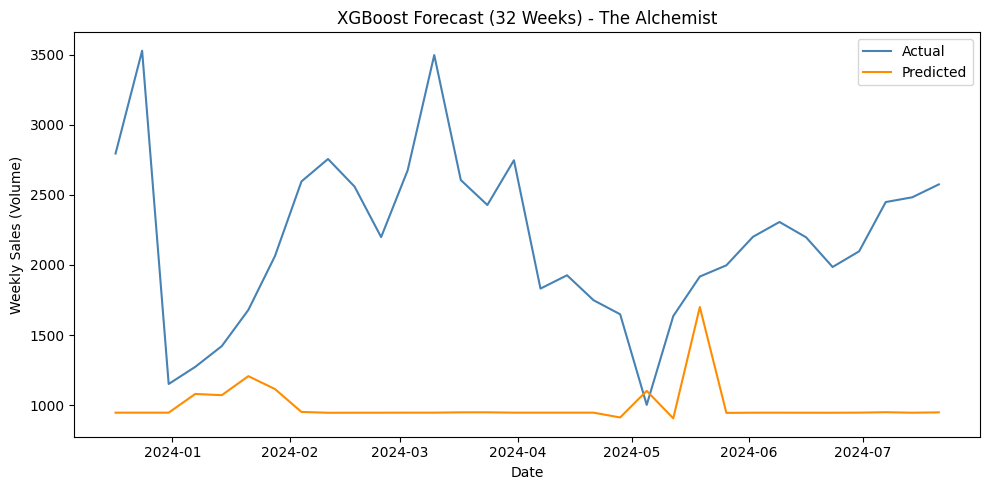


========================= Training XGBoost for The Very Hungry Caterpillar =========================
 Model trained for The Very Hungry Caterpillar
MAE: 372.16
MAPE: 17.31%


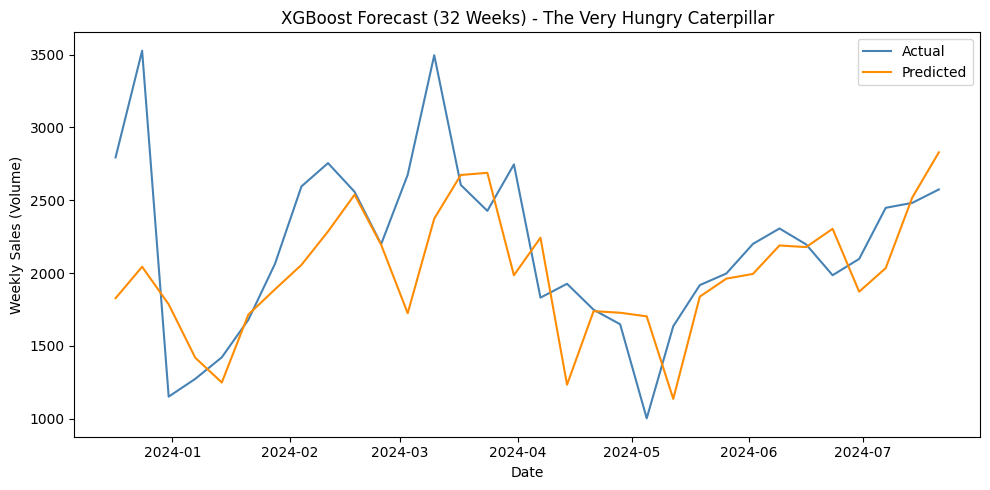

In [ ]:
#Pipeline for XGBoost
xgb_models = {}
xgb_results = {}

for title, data in data_ml.items():
    print(f"\n{'='*25} Training XGBoost for {title} {'='*25}")

    X_train, y_train = data['X_train'], data['y_train']

    # Create XGBoost model
    model = XGBRegressor(
        n_estimators=400,
        min_child_weight=1,
        max_depth=7,
        learning_rate=0.1,
        booster='gbtree',
        tree_method='exact',
        reg_alpha=0,
        subsample=0.5,
        validate_parameters=1,
        colsample_bylevel=1,
        colsample_bynode=1,
        colsample_bytree=1,
        gamma=0,
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train)
    xgb_models[title] = model

    print(f" Model trained for {title}")
    # Forecast
    preds = model.predict(X_test)

    # Compute metrics
    mae = mean_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    xgb_models[title] = model
    xgb_results[title] = {'MAE': mae, 'MAPE': mape, 'preds': preds, 'actual': y_test}

    # Print metrics
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(10,5))
    plt.plot(y_test.index, y_test, label='Actual', color='steelblue')
    plt.plot(y_test.index, preds, label='Predicted', color='darkorange')
    plt.title(f"XGBoost Forecast (32 Weeks) - {title}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales (Volume)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Define CV splitter
tscv = TimeSeriesSplit(n_splits=5)

window_options = [8, 12, 16, 20, 24]

# Parameter grid for tuning
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
#Function for XGBoost
def tune_xgboost(series, title, forecast_horizon, param_grid, tscv, window_options):
    """
    Tune XGBoost with different window lengths using TimeSeriesSplit CV.
    Returns the best model, best window, and performance metrics.
    """
    best_mae = np.inf
    best_window = None
    best_model = None
    X_test_final, y_test_final = None, None

    for window_length in window_options:
        print(f"\n--- Trying window_length = {window_length} for {title} ---")

        # Create lag features
        df = pd.DataFrame({'y': series})
        for lag in range(1, window_length + 1):
            df[f'lag_{lag}'] = df['y'].shift(lag)
        df = df.dropna()

        # Train/test split
        train = df.iloc[:-forecast_horizon]
        test = df.iloc[-forecast_horizon:]

        X_train, y_train = train.drop('y', axis=1), train['y']
        X_test, y_test = test.drop('y', axis=1), test['y']

        # Base model
        base_model = XGBRegressor(
            tree_method='exact',  # 'gpu_hist' if GPU enabled
            random_state=42,
            n_jobs=-1
        )

        # Grid Search CV
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=tscv,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)
        mae_cv = -grid_search.best_score_

        print(f"Best CV MAE for window {window_length}: {mae_cv:.2f}")

        # Track best
        if mae_cv < best_mae:
            best_mae = mae_cv
            best_window = window_length
            best_model = grid_search.best_estimator_
            X_test_final, y_test_final = X_test, y_test

    # --- Evaluate on test set ---
    preds = best_model.predict(X_test_final)
    mae = mean_absolute_error(y_test_final, preds)
    mape = mean_absolute_percentage_error(y_test_final, preds) * 100

    print(f"\n✅ Best window for {title}: {best_window}")
    print(f"Test MAE: {mae:.2f}, Test MAPE: {mape:.2f}%")

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(y_test_final.index, y_test_final, label='Actual', color='steelblue')
    plt.plot(y_test_final.index, preds, label='Predicted', color='darkorange')
    plt.title(f"Optimized XGBoost Forecast - {title}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales (Volume)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'model': best_model,
        'best_window': best_window,
        'mae': mae,
        'mape': mape,
        'best_params': best_model.get_params()
    }



========================= Tuning XGBoost for The Alchemist =========================

--- Trying window_length = 8 for The Alchemist ---
Best CV MAE for window 8: 95.60

--- Trying window_length = 12 for The Alchemist ---
Best CV MAE for window 12: 93.83

--- Trying window_length = 16 for The Alchemist ---
Best CV MAE for window 16: 95.29

--- Trying window_length = 20 for The Alchemist ---
Best CV MAE for window 20: 95.02

--- Trying window_length = 24 for The Alchemist ---
Best CV MAE for window 24: 98.77

✅ Best window for The Alchemist: 12
Test MAE: 120.81, Test MAPE: 20.46%


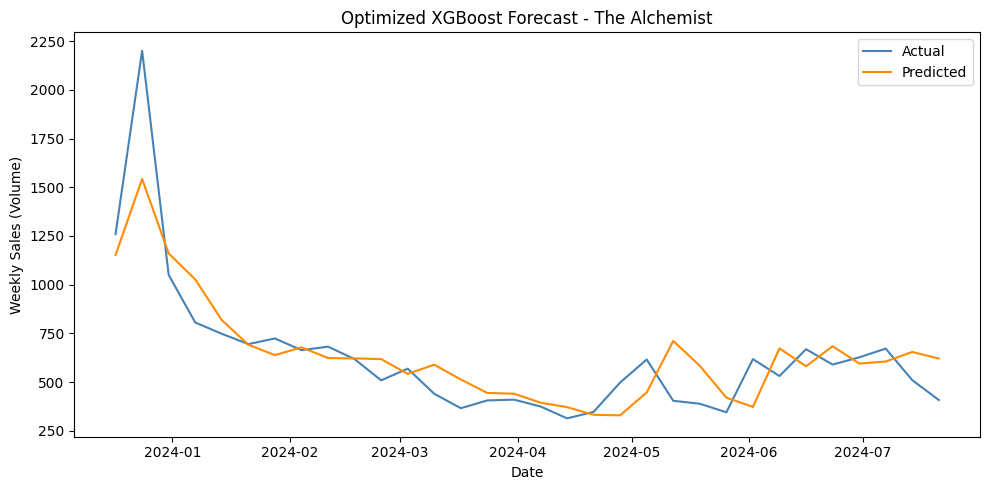


========================= Tuning XGBoost for The Very Hungry Caterpillar =========================

--- Trying window_length = 8 for The Very Hungry Caterpillar ---
Best CV MAE for window 8: 303.78

--- Trying window_length = 12 for The Very Hungry Caterpillar ---
Best CV MAE for window 12: 311.96

--- Trying window_length = 16 for The Very Hungry Caterpillar ---
Best CV MAE for window 16: 311.63

--- Trying window_length = 20 for The Very Hungry Caterpillar ---
Best CV MAE for window 20: 320.73

--- Trying window_length = 24 for The Very Hungry Caterpillar ---
Best CV MAE for window 24: 316.63

✅ Best window for The Very Hungry Caterpillar: 8
Test MAE: 346.19, Test MAPE: 17.06%


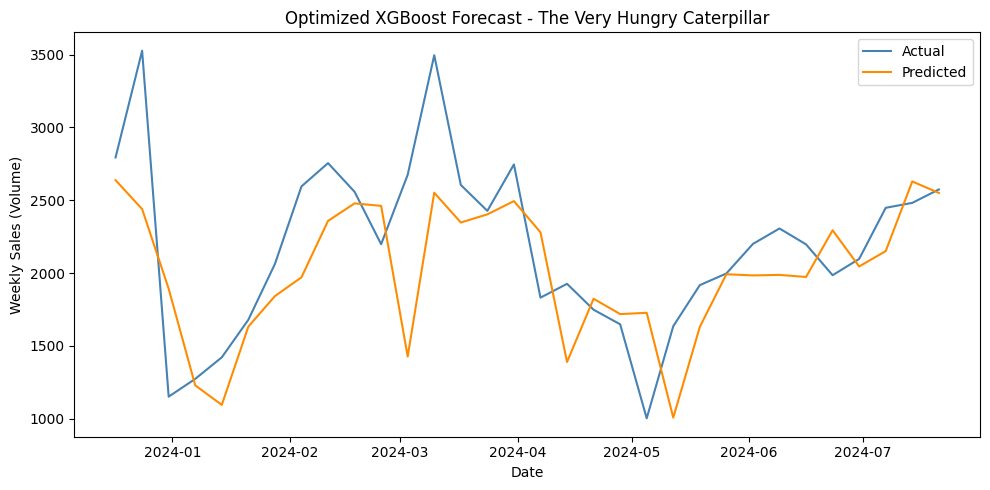

In [ ]:
xgb_tuned_results = {}

for isbn, title in title_map.items():
    print(f"\n{'='*25} Tuning XGBoost for {title} {'='*25}")
    series = target_df[target_df['ISBN'] == isbn].set_index('End Date')['Volume']
    series = series[series.index >= '2012-01-01']

    result = tune_xgboost(
        series=series,
        title=title,
        forecast_horizon=32,
        param_grid=param_grid,
        tscv=tscv,
        window_options=window_options
    )
    xgb_tuned_results[title] = result



========================= Full-range forecast with CI for The Alchemist =========================


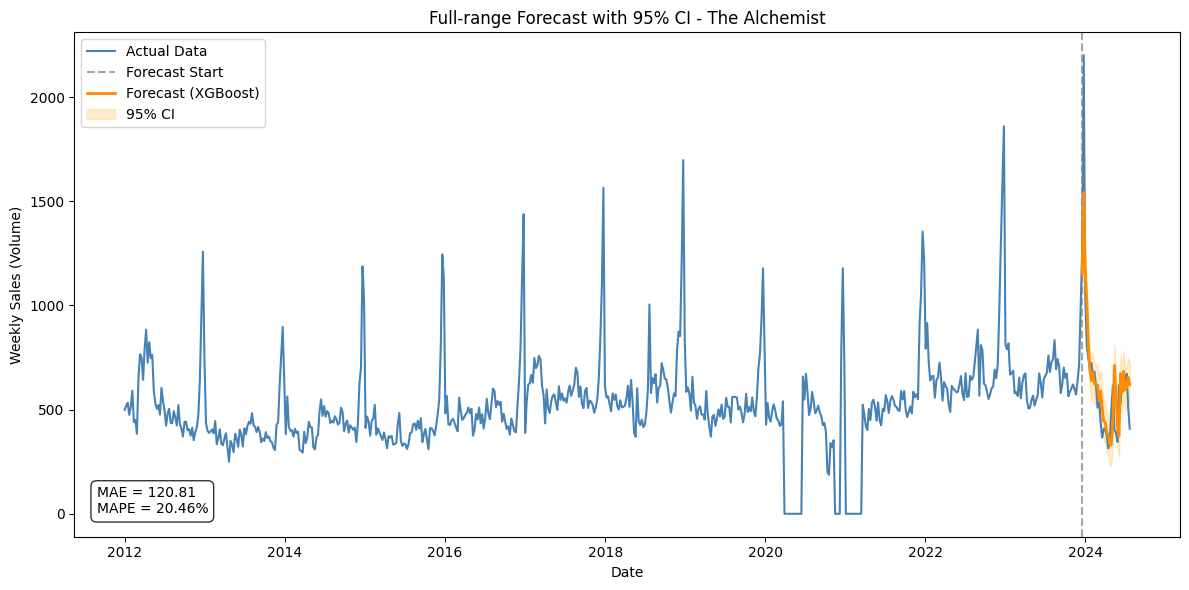


========================= Full-range forecast with CI for The Very Hungry Caterpillar =========================


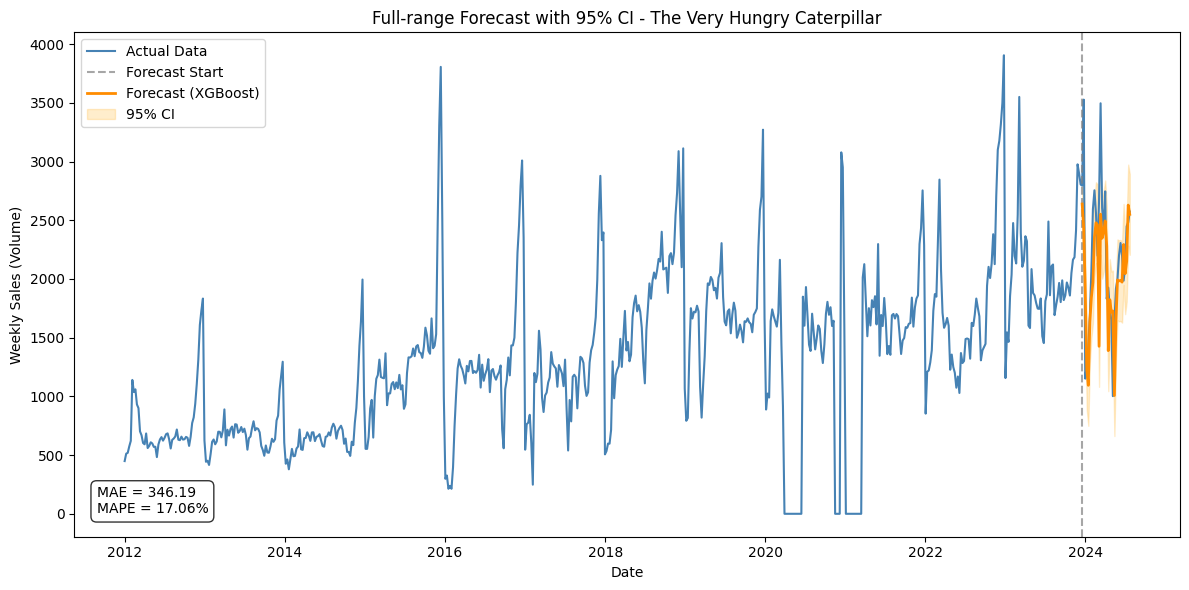

In [ ]:
# Full-range forecast + confidence intervals

for isbn, title in title_map.items():
    print(f"\n{'='*25} Full-range forecast with CI for {title} {'='*25}")

    # Extract original series
    series = target_df[target_df['ISBN'] == isbn].set_index('End Date')['Volume']
    series = series[series.index >= '2012-01-01']

    # Retrieve model and window length
    best_model = xgb_tuned_results[title]['model']
    best_window = xgb_tuned_results[title]['best_window']

    # Recreate feature matrix
    df = pd.DataFrame({'y': series})
    for lag in range(1, best_window + 1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()

    # Split train/test
    train = df.iloc[:-forecast_horizon]
    test = df.iloc[-forecast_horizon:]
    X_train, y_train = train.drop('y', axis=1), train['y']
    X_test, y_test = test.drop('y', axis=1), test['y']

    # Predictions
    preds = best_model.predict(X_test)

    # Compute metrics
    mae = mean_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    # Residuals std dev from training
    train_preds = best_model.predict(X_train)
    resid_std = np.std(y_train - train_preds)

    # 95% confidence interval
    ci_upper = preds + 1.96 * resid_std
    ci_lower = preds - 1.96 * resid_std

    # --- Plot ---
    plt.figure(figsize=(12,6))
    plt.plot(series.index, series.values, label='Actual Data', color='steelblue', linewidth=1.5)
    plt.axvline(x=y_test.index[0], color='gray', linestyle='--', alpha=0.7, label='Forecast Start')

    plt.plot(y_test.index, preds, label='Forecast (XGBoost)', color='darkorange', linewidth=2)
    plt.fill_between(y_test.index, ci_lower, ci_upper, color='orange', alpha=0.2, label='95% CI')

    # Text box with metrics
    textstr = f"MAE = {mae:.2f}\nMAPE = {mape:.2f}%"
    plt.gca().text(
        0.02, 0.10, textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
    )

    plt.title(f"Full-range Forecast with 95% CI - {title}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales (Volume)")
    plt.legend()
    plt.tight_layout()
    plt.show()


###LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Paramters
lookback = 12
forecast = 32

lstm_results = {}

In [ ]:
#Create sequences
def create_input_sequences(lookback, forecast, sequence_data):
    input_sequences, output_sequences = [], []
    for i in range(lookback, len(sequence_data) - forecast + 1):
        input_sequences.append(sequence_data[i - lookback: i])
        output_sequences.append(sequence_data[i: i + forecast])
    return np.array(input_sequences), np.array(output_sequences)

In [ ]:
#Function to create LSTM model
def tuned_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            hp.Int('input_unit', min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(lookback, 1)
        )
    )
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(
            LSTM(
                hp.Int(f'lstm_{i}_units', min_value=16, max_value=128, step=16),
                return_sequences=True
            )
        )
    model.add(
        LSTM(
            hp.Int('final_lstm_units', min_value=16, max_value=128, step=16)
        )
    )
    model.add(Dropout(hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(forecast, activation=hp.Choice('dense_activation', values=['relu', 'linear'], default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model


========================= Training Multi-step LSTM for The Alchemist =========================


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 12, 80)         │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 12, 64)         │        37,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 48)         │        21,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 12, 112)        │        72,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 80)             │        61,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,592 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,536 (865.38 KB)

 Trainable params: 221,536 (865.38 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step

 The Alchemist: MAE = 165.14, MAPE = 31.86% 



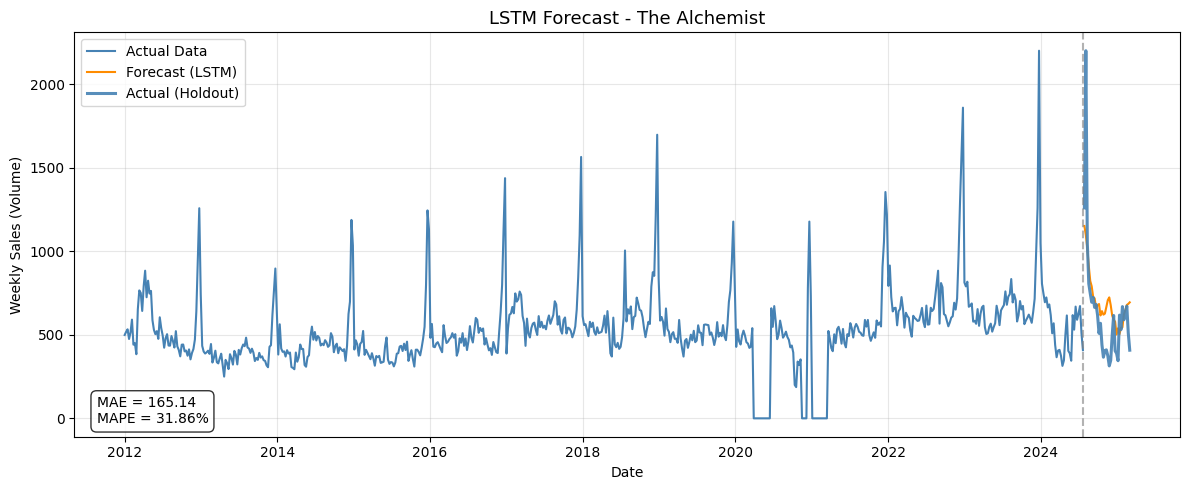


========================= Training Multi-step LSTM for The Very Hungry Caterpillar =========================


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 12, 112)        │       107,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 12, 80)         │        61,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 96)             │        67,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         3,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,360 (1.17 MB)

 Trainable params: 307,360 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step

 The Very Hungry Caterpillar: MAE = 378.22, MAPE = 18.57% 



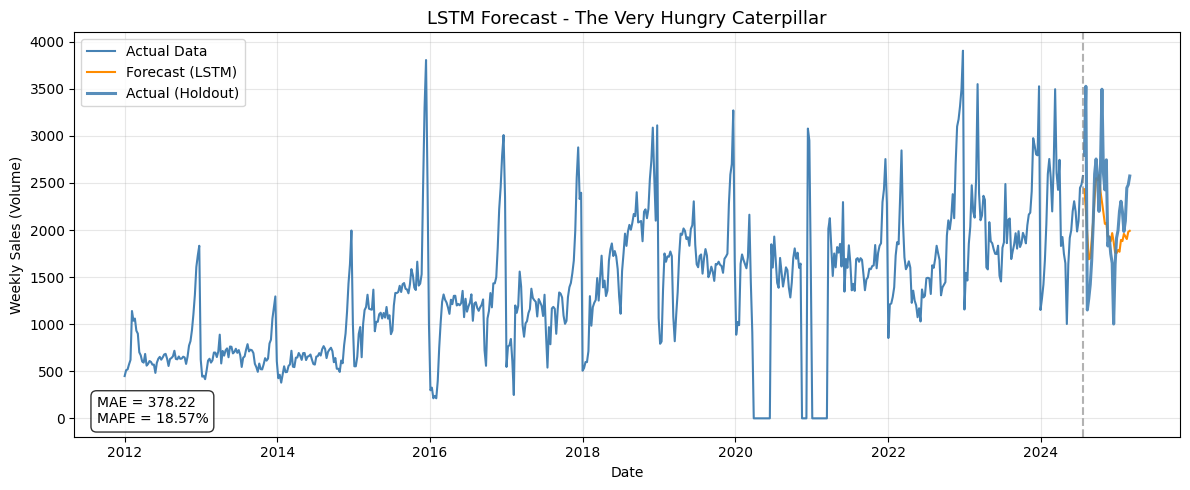

In [ ]:
# Model for each book
for isbn, title in title_map.items():
    print(f"\n{'='*25} Training Multi-step LSTM for {title} {'='*25}")

    # Prepare series
    series = target_df[target_df['ISBN'] == isbn].set_index('End Date')['Volume']
    series = series[series.index >= '2012-01-01']

    # Normalization
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    # Create sequences
    X, y = create_input_sequences(lookback, forecast, scaled_series)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split into training and test
    X_train, y_train = X[:-1], y[:-1]
    X_test, y_test = X[-1:], y[-1:]

    # Hyperparameter tuning
    tuner = kt.RandomSearch(
        tuned_model,
        objective='val_loss',
        max_trials=5,
        overwrite=True,
        directory='lstm_tuning',
        project_name=f"{title.replace(' ', '_')}_multi"
    )

    tuner.search(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Best model
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hp)
    best_model.summary()

    best_model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

    # Forecast
    last_input = X_test
    preds_scaled = best_model.predict(last_input)
    preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1))

    # Metrics
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(y_true, preds)
    mape = mean_absolute_percentage_error(y_true, preds) * 100

    # Save results
    lstm_results[title] = {'mae': mae, 'mape': mape, 'preds': preds, 'actual': y_true}

    print(f"\n {title}: MAE = {mae:.2f}, MAPE = {mape:.2f}% \n")

    # === Improved Plot ===
    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series.values, label='Actual Data', color='steelblue')

    # Forecast dates start one week after last known observation
    forecast_dates = pd.date_range(series.index[-1] + pd.Timedelta(weeks=1),
                                   periods=forecast, freq='W')

    # Plot forecast
    plt.plot(forecast_dates, preds.flatten(), color='darkorange', label='Forecast (LSTM)')

    plt.plot(forecast_dates,
         series.iloc[-forecast:].values,
         color='steelblue', linewidth=2.2, alpha=0.9, label='Actual (Holdout)')
    '''
    # Add confidence range (±5% for visualization)
    plt.fill_between(forecast_dates,
                     preds.flatten() * 0.95,
                     preds.flatten() * 1.05,
                     color='orange', alpha=0.2, label='Confidence Range (±5%)')
    '''

    # Vertical separation line
    plt.axvline(series.index[-1], color='gray', linestyle='--', alpha=0.6)

    # Add MAE / MAPE textbox
    textstr = f"MAE = {mae:.2f}\nMAPE = {mape:.2f}%"
    plt.gca().text(0.02, 0.10, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

    plt.title(f"LSTM Forecast - {title}", fontsize=13)
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales (Volume)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

##Hybrid Model

###Sequential Combination

In [ ]:
import statsmodels.api as sm

In [ ]:
sarima_results = {}
forecast_horizon = 32


========================= SARIMA Model for The Alchemist =========================


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  624
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -3178.058
Date:                            Sat, 01 Nov 2025   AIC                           6366.116
Time:                                    09:09:03   BIC                           6387.356
Sample:                                01-01-2012   HQIC                          6374.438
                                     - 12-10-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3288      0.065      5.077      0.000       0.202       0.456
ma.L1         -0.7200      0.052   

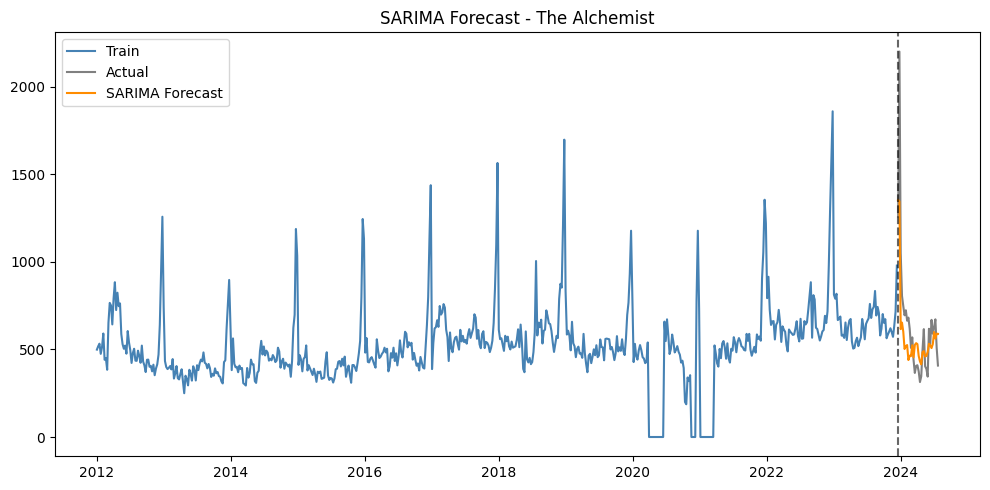


========================= SARIMA Model for The Very Hungry Caterpillar =========================


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  624
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -3773.374
Date:                            Sat, 01 Nov 2025   AIC                           7556.748
Time:                                    09:09:43   BIC                           7577.988
Sample:                                01-01-2012   HQIC                          7565.070
                                     - 12-10-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7404      0.032     23.441      0.000       0.679       0.802
ma.L1         -0.9629      0.015   

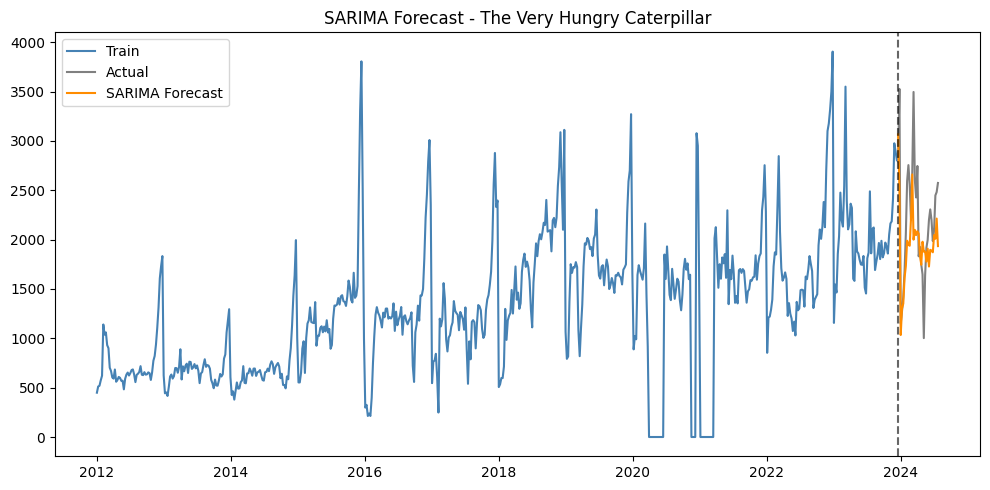

In [ ]:
for isbn, title in title_map.items():
    print(f"\n{'='*25} SARIMA Model for {title} {'='*25}")

    #Prepare series
    series = target_df[target_df['ISBN'] == isbn].set_index('End Date')['Volume']
    series = series[series.index >= '2012-01-01']

    # Train/Test split
    train = series.iloc[:-forecast_horizon]
    test = series.iloc[-forecast_horizon:]

    #Fit SARIMA
    model_sarima = sm.tsa.statespace.SARIMAX(train,
                                      order=(1, 1, 1),
                                      seasonal_order=(1, 1, 1, 52),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    sarima_fit = model_sarima.fit(disp=False)

    print(sarima_fit.summary())

    #Forecast
    sarima_forecast = sarima_fit.forecast(steps=forecast_horizon)

    #Evaluate
    mae = mean_absolute_error(test, sarima_forecast)
    mape = mean_absolute_percentage_error(test, sarima_forecast) * 100
    print(f"\nSARIMA → {title}: MAE = {mae:.2f}, MAPE = {mape:.2f}%")

    # Save model + results
    sarima_results[title] = {
        'model': sarima_fit,
        'train': train,
        'test': test,
        'forecast': sarima_forecast,
        'mae': mae,
        'mape': mape
    }

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train', color='steelblue')
    plt.plot(test.index, test, label='Actual', color='gray')
    plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='darkorange')
    plt.axvline(test.index[0], color='black', linestyle='--', alpha=0.6)
    plt.title(f"SARIMA Forecast - {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()


Residuals summary for The Alchemist:
count    624.000000
mean       0.495996
std      117.442846
min     -884.313400
25%      -51.056803
50%       -2.527917
75%       47.857558
max      695.145514
dtype: float64


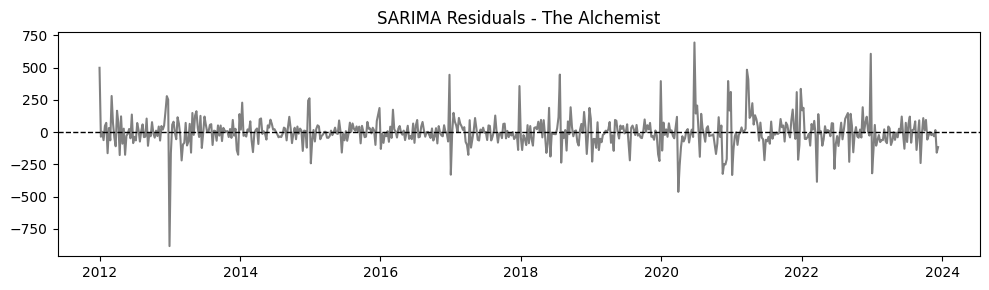


Residuals summary for The Very Hungry Caterpillar:
count     624.000000
mean        7.682225
std       334.131363
min     -1785.111273
25%      -100.528663
50%        12.390904
75%       112.952070
max      2752.865953
dtype: float64


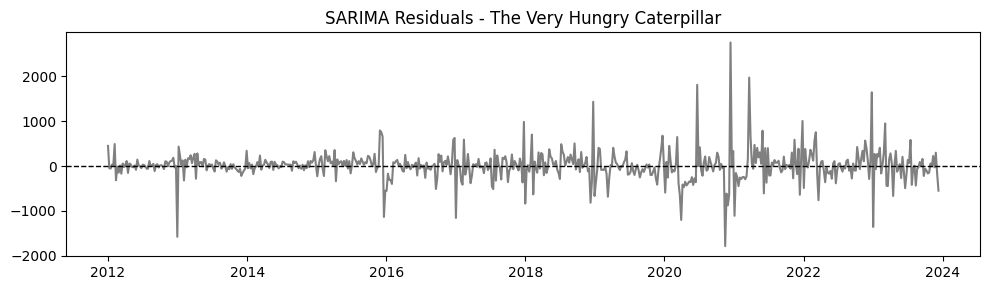

In [ ]:
# Extract SARIMA residuals
sarima_residuals = {}

for title, res in sarima_results.items():
    model_fit = res['model']
    train = res['train']

    # Residuals from SARIMA on training data
    residuals = model_fit.resid

    print(f"\nResiduals summary for {title}:")
    print(residuals.describe())

    plt.figure(figsize=(10, 3))
    plt.plot(residuals, color='gray')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"SARIMA Residuals - {title}")
    plt.tight_layout()
    plt.show()

    # Save for LSTM modeling
    sarima_residuals[title] = residuals

In [ ]:
# Function to create input/output sequences for residuals
def create_residual_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(lookback, len(data) - forecast_horizon + 1):
        X.append(data[i - lookback:i])
        y.append(data[i:i + forecast_horizon])
    return np.array(X), np.array(y)

In [ ]:
lookback = 12
residual_forecast_horizon = forecast_horizon

In [ ]:
lstm_residual_results = {}

In [ ]:
for title, residuals in sarima_residuals.items():
    print(f"\n{'='*25} Training LSTM on SARIMA Residuals for {title} {'='*25}")

    # Normalize residuals
    scaler = MinMaxScaler()
    scaled_resid = scaler.fit_transform(residuals.values.reshape(-1, 1)).flatten()

    # Create sequences
    X, y = create_residual_sequences(scaled_resid, lookback, residual_forecast_horizon)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split train/test
    X_train, y_train = X[:-1], y[:-1]
    X_test, y_test = X[-1:], y[-1:]

    # Build simple LSTM model
    model_res = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(32),
        Dense(residual_forecast_horizon)
    ])
    model_res.compile(loss='mse', optimizer='adam')

    # Train model
    model_res.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Forecast residuals
    preds_scaled = model_res.predict(X_test)
    preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1))

    lstm_residual_results[title] = {
        'model': model_res,
        'preds': preds,
        'y_test': scaler.inverse_transform(y_test.reshape(-1, 1))
    }

    print(f"LSTM trained on residuals for {title}")


========================= Training LSTM on SARIMA Residuals for The Alchemist =========================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
LSTM trained on residuals for The Alchemist

========================= Training LSTM on SARIMA Residuals for The Very Hungry Caterpillar =========================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
LSTM trained on residuals for The Very Hungry Caterpillar


In [ ]:
def build_residual_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        hp.Int('units_1', min_value=32, max_value=128, step=16),
        return_sequences=True,
        input_shape=(lookback, 1)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('units_2', min_value=16, max_value=64, step=16)))
    model.add(Dense(residual_forecast_horizon, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mse'
    )
    return model

In [ ]:
tuned_residual_results = {}

for title, residuals in sarima_residuals.items():
    print(f"\n{'='*25} Tuning LSTM on Residuals for {title} {'='*25}")

    # Normalize residuals
    scaler = MinMaxScaler()
    scaled_resid = scaler.fit_transform(residuals.values.reshape(-1, 1)).flatten()

    # Create sequences
    X, y = create_residual_sequences(scaled_resid, lookback, residual_forecast_horizon)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    X_train, y_train = X[:-1], y[:-1]
    X_test, y_test = X[-1:], y[-1:]

    # KerasTuner search
    tuner = kt.RandomSearch(
        build_residual_lstm_model,
        objective='val_loss',
        max_trials=5,
        directory='residual_tuning',
        project_name=f"{title.replace(' ', '_')}_residuals"
    )

    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hp)

    # Train final tuned model
    best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Forecast residuals
    preds_scaled = best_model.predict(X_test)
    preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1))

    tuned_residual_results[title] = {
        'model': best_model,
        'preds': preds,
        'y_test': scaler.inverse_transform(y_test.reshape(-1, 1)),
        'hp': best_hp
    }

    print(f"Best model for {title}:")
    for k, v in best_hp.values.items():
        print(f"  {k}: {v}")


========================= Tuning LSTM on Residuals for The Alchemist =========================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Best model for The Alchemist:
  units_1: 96
  dropout_1: 0.2
  units_2: 16
  learning_rate: 0.0032234655818265466

========================= Tuning LSTM on Residuals for The Very Hungry Caterpillar =========================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Best model for The Very Hungry Caterpillar:
  units_1: 96
  dropout_1: 0.4
  units_2: 16
  learning_rate: 0.002874055088465658



========================= Hybrid Model (SARIMA + LSTM) for The Alchemist =========================
✅ Hybrid Model The Alchemist: MAE = 141.54, MAPE = 21.87%


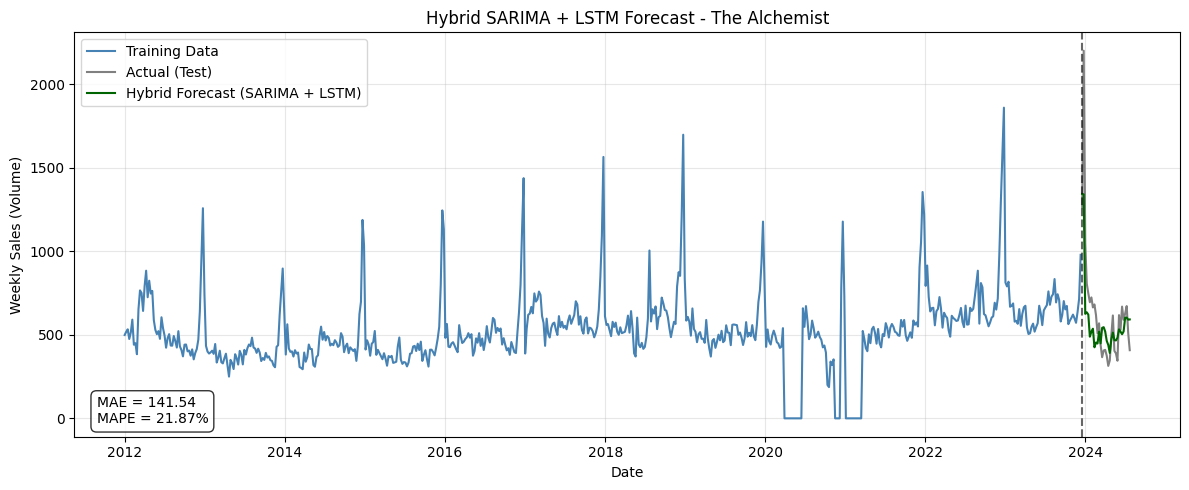


========================= Hybrid Model (SARIMA + LSTM) for The Very Hungry Caterpillar =========================
✅ Hybrid Model The Very Hungry Caterpillar: MAE = 362.12, MAPE = 16.09%


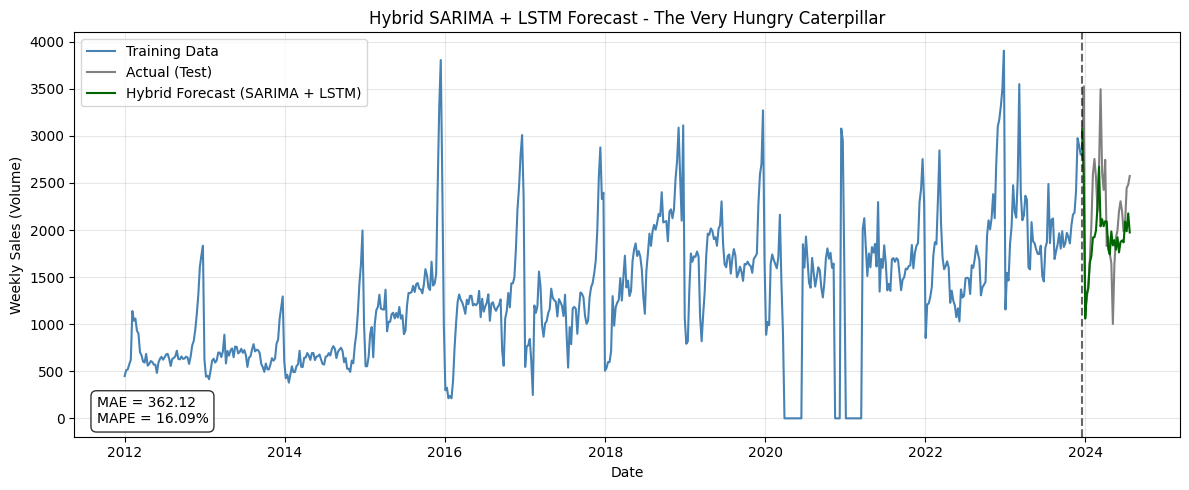


=== HYBRID MODEL PERFORMANCE SUMMARY ===
The Alchemist: MAE = 141.54, MAPE = 21.87%
The Very Hungry Caterpillar: MAE = 362.12, MAPE = 16.09%


In [ ]:
hybrid_results = {}

for title in sarima_results.keys():
    print(f"\n{'='*25} Hybrid Model (SARIMA + LSTM) for {title} {'='*25}")

    # Retrieve forecasts
    sarima_forecast = sarima_results[title]['forecast']
    lstm_residual_forecast = tuned_residual_results[title]['preds'].flatten()
    actual = sarima_results[title]['test']

    # Combine predictions
    hybrid_forecast = sarima_forecast.values + lstm_residual_forecast

    # Compute metrics
    mae = mean_absolute_error(actual, hybrid_forecast)
    mape = mean_absolute_percentage_error(actual, hybrid_forecast) * 100

    hybrid_results[title] = {
        'hybrid_forecast': hybrid_forecast,
        'actual': actual,
        'mae': mae,
        'mape': mape
    }

    print(f"✅ Hybrid Model {title}: MAE = {mae:.2f}, MAPE = {mape:.2f}%")

    # === Plot Final Forecast ===
    plt.figure(figsize=(12, 5))
    plt.plot(sarima_results[title]['train'].index,
             sarima_results[title]['train'].values,
             label='Training Data', color='steelblue')

    plt.plot(actual.index, actual.values,
             color='gray', label='Actual (Test)')
    plt.plot(actual.index, hybrid_forecast,
             color='darkgreen', label='Hybrid Forecast (SARIMA + LSTM)')

    plt.axvline(actual.index[0], color='black', linestyle='--', alpha=0.6)
    textstr = f"MAE = {mae:.2f}\nMAPE = {mape:.2f}%"
    plt.gca().text(0.02, 0.10, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

    plt.title(f"Hybrid SARIMA + LSTM Forecast - {title}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales (Volume)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Summary Table ===
print("\n=== HYBRID MODEL PERFORMANCE SUMMARY ===")
for title, res in hybrid_results.items():
    print(f"{title}: MAE = {res['mae']:.2f}, MAPE = {res['mape']:.2f}%")

###Parallel Combination

In [ ]:
def build_parallel_lstm_model(hp):
    model_parallel = Sequential()
    model_parallel.add(LSTM(
        hp.Int('units_1', min_value=32, max_value=128, step=16),
        return_sequences=True,
        input_shape=(lookback, 1)
    ))
    model_parallel.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model_parallel.add(LSTM(hp.Int('units_2', min_value=16, max_value=64, step=16)))
    model_parallel.add(Dense(forecast_horizon, activation='linear'))
    model_parallel.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mse'
    )
    return model_parallel

In [ ]:
#LSTM model
parallel_lstm_results = {}

for isbn, title in title_map.items():
    print(f"\n{'='*25} Parallel LSTM Training for {title} {'='*25}")
    series = target_df[target_df['ISBN'] == isbn].set_index('End Date')['Volume']
    series = series[series.index >= '2012-01-01']

    train = series.iloc[:-forecast_horizon]
    test = series.iloc[-forecast_horizon:]

    # Normalize
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    # Create sequences
    X, y = create_residual_sequences(scaled_series, lookback, forecast_horizon)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    X_train, y_train = X[:-1], y[:-1]
    X_test, y_test = X[-1:], y[-1:]

    # Hyperparameter tuning
    tuner_parallel = kt.RandomSearch(
        build_parallel_lstm_model,
        objective='val_loss',
        max_trials=5,
        overwrite=True,
        directory='parallel_lstm_tuning',
        project_name=f"{title.replace(' ', '_')}_parallel"
    )

    tuner_parallel.search(X_train, y_train, epochs=80, validation_split=0.2, verbose=0)
    best_hp_parallel = tuner_parallel.get_best_hyperparameters(num_trials=1)[0]
    best_model_parallel = tuner_parallel.hypermodel.build(best_hp_parallel)
    best_model_parallel.fit(X_train, y_train, epochs=120, batch_size=32, verbose=0)

    preds_scaled_parallel = best_model_parallel.predict(X_test)
    preds_parallel = scaler.inverse_transform(preds_scaled_parallel.reshape(-1, 1))

    parallel_lstm_results[title] = {
        'model': best_model_parallel,
        'preds': preds_parallel.flatten(),
        'actual': test.values,
        'scaler': scaler
    }

    print(f"Parallel LSTM model trained for {title}")


========================= Parallel LSTM Training for The Alchemist =========================


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Parallel LSTM model trained for The Alchemist

========================= Parallel LSTM Training for The Very Hungry Caterpillar =========================


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Parallel LSTM model trained for The Very Hungry Caterpillar


In [ ]:
#Weighted Combination
weights = np.linspace(0, 1, 100)

In [ ]:
parallel_hybrid_results = {}

for title in sarima_results.keys():
    sarima_forecast = sarima_results[title]['forecast'].values
    parallel_lstm_forecast = parallel_lstm_results[title]['preds']
    actual = sarima_results[title]['test']

    best_weight_parallel = None
    best_mae_parallel = np.inf
    best_mape_parallel = np.inf
    best_forecast_parallel = None

    # Try different weight combinations
    for w in weights:
        parallel_hybrid_forecast = w * sarima_forecast + (1 - w) * parallel_lstm_forecast
        parallel_mae = mean_absolute_error(actual, parallel_hybrid_forecast)
        parallel_mape = mean_absolute_percentage_error(actual, parallel_hybrid_forecast) * 100

        if parallel_mae < best_mae_parallel:
            best_mae_parallel = parallel_mae
            best_mape_parallel = parallel_mape
            best_weight_parallel = w
            best_forecast_parallel = parallel_hybrid_forecast

    parallel_hybrid_results[title] = {
        'best_weight': best_weight_parallel,
        'mae': best_mae_parallel,
        'mape': best_mape_parallel,
        'forecast': best_forecast_parallel,
        'actual': actual
    }

    print(f"\n{title} — Best Weight = {best_weight_parallel:.2f} | MAE = {best_mae_parallel:.2f}, MAPE = {best_mape_parallel:.2f}%")


The Alchemist — Best Weight = 0.84 | MAE = 137.86, MAPE = 22.51%

The Very Hungry Caterpillar — Best Weight = 0.94 | MAE = 364.88, MAPE = 16.17%


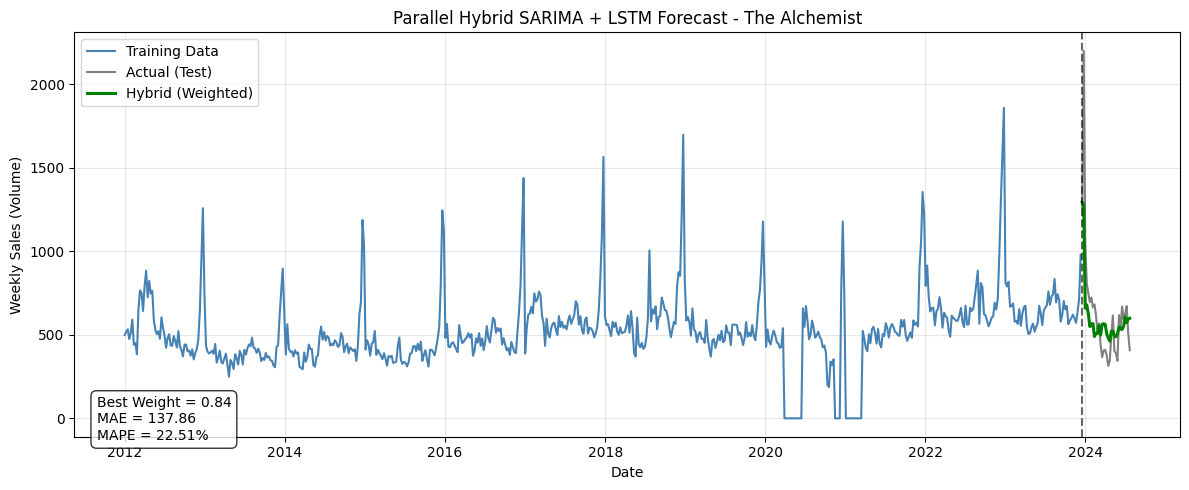

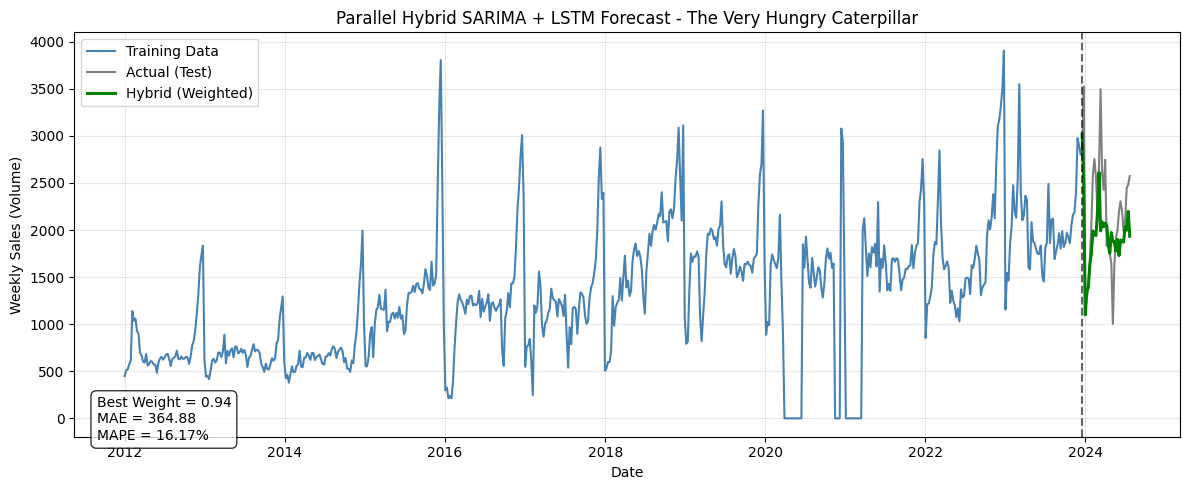

In [ ]:
#Plot results
for title, res in parallel_hybrid_results.items():
    actual = res['actual']
    hybrid_forecast = res['forecast']
    sarima_forecast = sarima_results[title]['forecast']
    lstm_forecast = parallel_lstm_results[title]['preds']

    plt.figure(figsize=(12, 5))
    plt.plot(sarima_results[title]['train'].index,
             sarima_results[title]['train'].values, label='Training Data', color='steelblue')

    plt.plot(actual.index, actual.values, color='gray', label='Actual (Test)')
    #plt.plot(actual.index, sarima_forecast, '--', color='orange', label='SARIMA Forecast')
    #plt.plot(actual.index, lstm_forecast, '--', color='purple', label='LSTM Forecast')
    plt.plot(actual.index, hybrid_forecast, color='green', linewidth=2.2, label='Hybrid (Weighted)')

    plt.axvline(actual.index[0], color='black', linestyle='--', alpha=0.6)
    textstr = f"Best Weight = {res['best_weight']:.2f}\nMAE = {res['mae']:.2f}\nMAPE = {res['mape']:.2f}%"
    plt.gca().text(0.02, 0.10, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

    plt.title(f"Parallel Hybrid SARIMA + LSTM Forecast - {title}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales (Volume)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
#Summary
print("\n=== PARALLEL HYBRID MODEL PERFORMANCE SUMMARY ===")
for title, res in parallel_hybrid_results.items():
    print(f"{title}: Weight = {res['best_weight']:.4f} | MAE = {res['mae']:.2f}, MAPE = {res['mape']:.2f}%")


=== PARALLEL HYBRID MODEL PERFORMANCE SUMMARY ===
The Alchemist: Weight = 0.8384 | MAE = 137.86, MAPE = 22.51%
The Very Hungry Caterpillar: Weight = 0.9394 | MAE = 364.88, MAPE = 16.17%


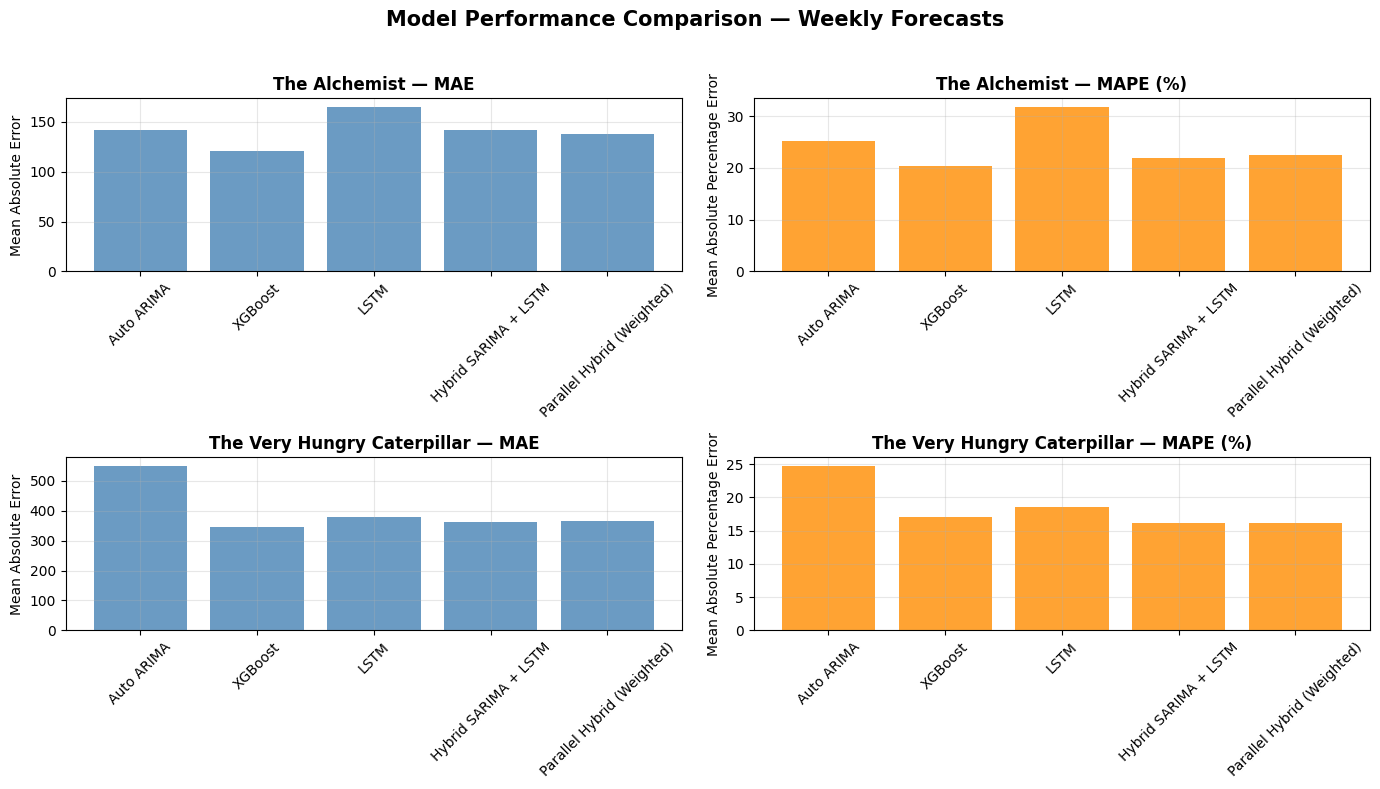

In [ ]:
# Data
data = {
    'Book Title': [
        'The Alchemist', 'The Alchemist', 'The Alchemist', 'The Alchemist', 'The Alchemist',
        'The Very Hungry Caterpillar', 'The Very Hungry Caterpillar', 'The Very Hungry Caterpillar',
        'The Very Hungry Caterpillar', 'The Very Hungry Caterpillar'
    ],
    'Model': [
        'Auto ARIMA', 'XGBoost', 'LSTM', 'Hybrid SARIMA + LSTM', 'Parallel Hybrid (Weighted)',
        'Auto ARIMA', 'XGBoost', 'LSTM', 'Hybrid SARIMA + LSTM', 'Parallel Hybrid (Weighted)'
    ],
    'MAE': [141.83, 120.81, 165.14, 141.54, 137.86, 550.92, 346.19, 378.22, 362.12, 364.88],
    'MAPE': [25.18, 20.46, 31.86, 21.87, 22.51, 24.79, 17.06, 18.57, 16.09, 16.17]
}

df = pd.DataFrame(data)

# Separate by book
df_a = df[df['Book Title'] == 'The Alchemist']
df_c = df[df['Book Title'] == 'The Very Hungry Caterpillar']

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("Model Performance Comparison — Weekly Forecasts", fontsize=15, weight='bold')

# === The Alchemist MAE ===
axes[0, 0].bar(df_a['Model'], df_a['MAE'], color='steelblue', alpha=0.8)
axes[0, 0].set_title("The Alchemist — MAE", fontsize=12, weight='bold')
axes[0, 0].set_ylabel("Mean Absolute Error")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# === The Alchemist MAPE ===
axes[0, 1].bar(df_a['Model'], df_a['MAPE'], color='darkorange', alpha=0.8)
axes[0, 1].set_title("The Alchemist — MAPE (%)", fontsize=12, weight='bold')
axes[0, 1].set_ylabel("Mean Absolute Percentage Error")
axes[0, 1].grid(alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# === The Very Hungry Caterpillar MAE ===
axes[1, 0].bar(df_c['Model'], df_c['MAE'], color='steelblue', alpha=0.8)
axes[1, 0].set_title("The Very Hungry Caterpillar — MAE", fontsize=12, weight='bold')
axes[1, 0].set_ylabel("Mean Absolute Error")
axes[1, 0].grid(alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# === The Very Hungry Caterpillar MAPE ===
axes[1, 1].bar(df_c['Model'], df_c['MAPE'], color='darkorange', alpha=0.8)
axes[1, 1].set_title("The Very Hungry Caterpillar — MAPE (%)", fontsize=12, weight='bold')
axes[1, 1].set_ylabel("Mean Absolute Percentage Error")
axes[1, 1].grid(alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##Monthly Prediction

Monthly dataset created
Title
The Alchemist                  151
The Very Hungry Caterpillar    151
dtype: int64


Month  Volume           ISBN          Title
0 2012-01-01    2539  9780722532935  The Alchemist
1 2012-02-01    1866  9780722532935  The Alchemist
2 2012-03-01    2813  9780722532935  The Alchemist
3 2012-04-01    3971  9780722532935  The Alchemist
4 2012-05-01    2385  9780722532935  The Alchemist

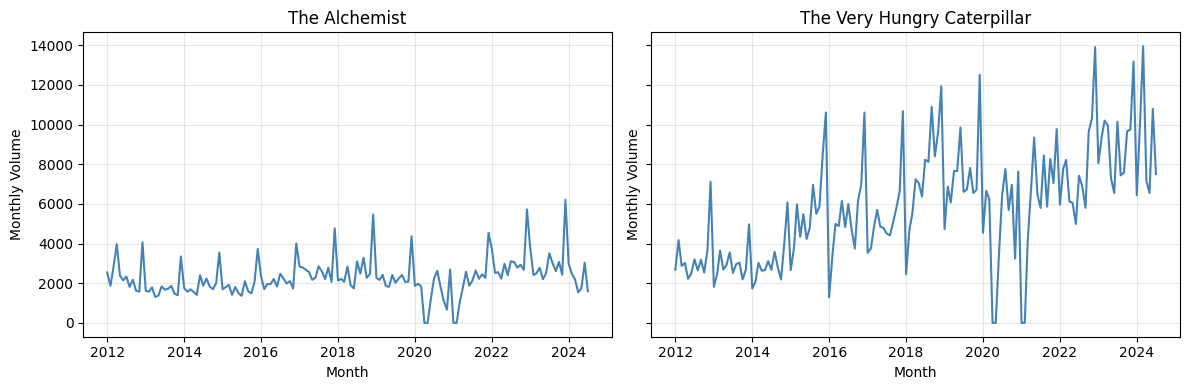

In [ ]:
#Aggregate in monthly data

#Filtering for books and data
books = list(title_map.keys())
weekly_2books = (
    target_df[target_df['ISBN'].isin(books)]
    .loc[target_df['End Date'] >= '2012-01-01', ['ISBN','End Date','Volume']]
    .copy()
)

#datetime index setting
weekly_2books = weekly_2books.set_index('End Date').sort_index()

#Resample to monthly
monthly_list = []
for isbn in books:
    s = (
        weekly_2books[weekly_2books['ISBN'] == isbn]['Volume']
        .resample('MS').sum()
        .asfreq('MS', fill_value=0)
        .to_frame(name='Volume')
    )
    s['ISBN'] = isbn
    s['Title'] = title_map[isbn]
    s = s.reset_index().rename(columns={'End Date':'Month'})
    monthly_list.append(s)

monthly_df = pd.concat(monthly_list, ignore_index=True)

print("Monthly dataset created")
print(monthly_df.groupby('Title').size())
display(monthly_df.head())

#anity plots
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i, (isbn, title) in enumerate(title_map.items()):
    tmp = monthly_df[monthly_df['ISBN'] == isbn]
    ax[i].plot(tmp['Month'], tmp['Volume'], color='steelblue')
    ax[i].set_title(title)
    ax[i].set_xlabel('Month'); ax[i].set_ylabel('Monthly Volume')
    ax[i].grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
def create_xgb_features(series, lag_window):
  """
  Given a pandas Series (monthly volume), create lag features for supervised learning.
  """
  df = pd.DataFrame({'y':series})
  for lag in range (1, lag_window+1):
    df[f'lag_{lag}'] = df['y'].shift(lag)
  df.dropna()
  x=df.drop(columns=['y'])
  y=df['y']
  return x, y

In [ ]:
#XGBoost monthly model parameter
forecast_horizon_months = 8
lag_window = [6, 12, 18, 24]

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_monthly_results = {}

# Custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


========================= XGBoost Monthly Forecast (Tuned) for The Alchemist =========================
→ lag_window=6 | MAE=874.76, MAPE=32.20% | Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.6}
→ lag_window=12 | MAE=700.68, MAPE=32.02% | Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400, 'subsample': 0.8}
→ lag_window=18 | MAE=746.60, MAPE=31.37% | Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.6}
→ lag_window=24 | MAE=836.30, MAPE=36.30% | Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.6}

 Best model for The Alchemist: lag_window=12, MAE=700.68, MAPE=32.02%


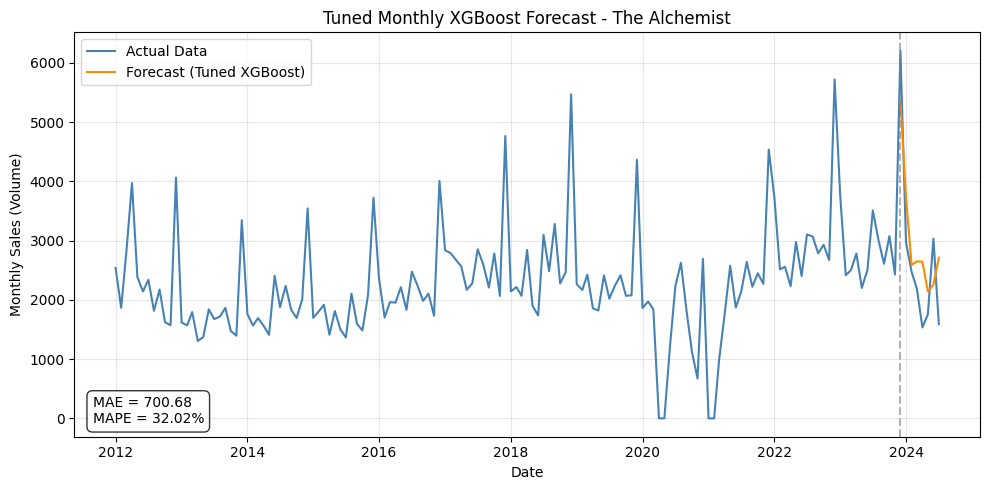


========================= XGBoost Monthly Forecast (Tuned) for The Very Hungry Caterpillar =========================
→ lag_window=6 | MAE=2800.68, MAPE=28.77% | Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.6}
→ lag_window=12 | MAE=1853.20, MAPE=17.52% | Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8}
→ lag_window=18 | MAE=2100.05, MAPE=19.93% | Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.8}
→ lag_window=24 | MAE=2214.78, MAPE=21.84% | Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600, 'subsample': 0.6}

 Best model for The Very Hungry Caterpillar: lag_window=12, MAE=1853.20, MAPE=17.52%


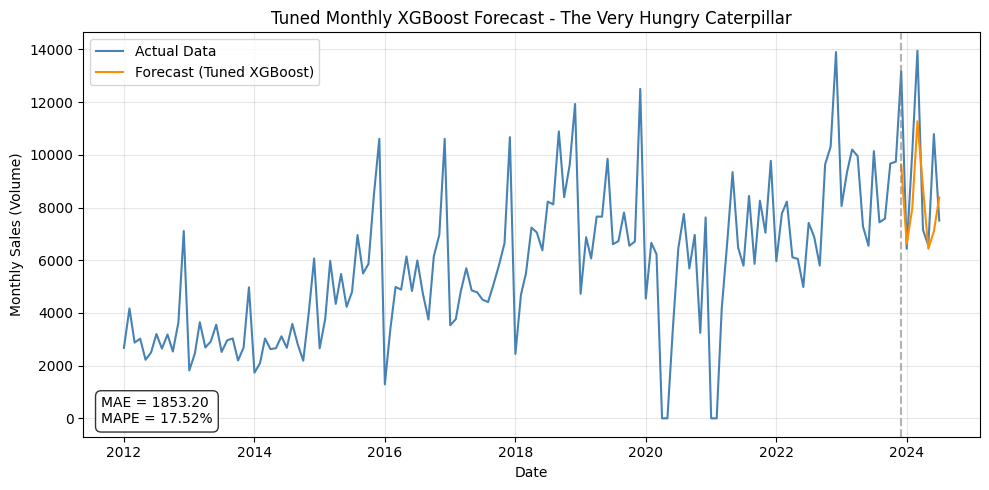

In [ ]:
#Train and forecast
for isbn, title in title_map.items():
    print(f"\n{'='*25} XGBoost Monthly Forecast (Tuned) for {title} {'='*25}")

    book_df = monthly_df[monthly_df['ISBN'] == isbn].set_index('Month').sort_index()
    series = book_df['Volume']

    best_score_mXGB = np.inf
    best_model_mXGB = None
    best_lag_mXGB = None

    for lag in lag_window:
        X, y = create_xgb_features(series, lag)
        X_train, X_test = X.iloc[:-forecast_horizon_months], X.iloc[-forecast_horizon_months:]
        y_train, y_test = y.iloc[:-forecast_horizon_months], y.iloc[-forecast_horizon_months:]

        # Model
        model_mXGB = XGBRegressor(random_state=42, n_jobs=-1)

        # Time series CV
        tscv = TimeSeriesSplit(n_splits=3)

        # Grid Search
        grid_mXGB = GridSearchCV(
            estimator=model_mXGB,
            param_grid=param_grid,
            scoring=mae_scorer,
            cv=tscv,
            verbose=0
        )
        grid_mXGB.fit(X_train, y_train)

        # Evaluate best model on holdout
        preds_mXGB = grid_mXGB.best_estimator_.predict(X_test)
        mae_mXGB = mean_absolute_error(y_test, preds_mXGB)
        mape_mXGB = mean_absolute_percentage_error(y_test, preds_mXGB) * 100

        print(f"→ lag_window={lag} | MAE={mae_mXGB:.2f}, MAPE={mape_mXGB:.2f}% | Best params: {grid_mXGB.best_params_}")

        # Track best overall
        if mae_mXGB < best_score_mXGB:
            best_score_mXGB = mae_mXGB
            best_model_mXGB = grid_mXGB.best_estimator_
            best_lag_mXGB = lag
            best_preds_mXGB = preds_mXGB
            best_y_test = y_test

    # Save final results
    xgb_monthly_results[title] = {
        'model': best_model_mXGB,
        'lag_window': best_lag_mXGB,
        'mae': best_score_mXGB,
        'mape': mean_absolute_percentage_error(best_y_test, best_preds_mXGB) * 100,
        'preds': best_preds_mXGB,
        'actual': best_y_test
    }

    print(f"\n Best model for {title}: lag_window={best_lag_mXGB}, MAE={best_score_mXGB:.2f}, MAPE={xgb_monthly_results[title]['mape']:.2f}%")

    # Plot results
    plt.figure(figsize=(10,5))
    plt.plot(series.index, series.values, label='Actual Data', color='steelblue')
    plt.plot(best_y_test.index, best_preds_mXGB, color='darkorange', label='Forecast (Tuned XGBoost)')
    plt.axvline(best_y_test.index[0], color='gray', linestyle='--', alpha=0.6)
    textstr = f"MAE = {best_score_mXGB:.2f}\nMAPE = {xgb_monthly_results[title]['mape']:.2f}%"
    plt.gca().text(0.02, 0.10, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
    plt.title(f"Tuned Monthly XGBoost Forecast - {title}")
    plt.xlabel("Date")
    plt.ylabel("Monthly Sales (Volume)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Summary of Best XGBoost Monthly Models
print("\n" + "="*60)
print("SUMMARY — Best Tuned XGBoost Monthly Models")
print("="*60)

summary_rows = []
for title, res in xgb_monthly_results.items():
    summary_rows.append({
        'Book': title,
        'Best Lag Window': res['lag_window'],
        'MAE': round(res['mae'], 2),
        'MAPE (%)': round(res['mape'], 2),
        'Best Params': res['model'].get_params()
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df[['Book', 'Best Lag Window', 'MAE', 'MAPE (%)']])


SUMMARY — Best Tuned XGBoost Monthly Models


Book  Best Lag Window      MAE  MAPE (%)
0                The Alchemist               12   700.68     32.02
1  The Very Hungry Caterpillar               12  1853.20     17.52

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#SARIMA hyperparameter
p = d = q = range(0,3)
P = D = Q = range (0,2)
m = 12

pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q, [m]))

sarima_monthly_tuned_results = {}


========================= SARIMA (MAE-Optimized) Monthly Model for The Alchemist =========================
Tuning SARIMA hyperparameters based on MAE
Best SARIMA(1, 2, 0) × Seasonal(1, 0, 1, 12) | MAE=488.95
→ Final Evaluation | MAE = 488.95, MAPE = 17.14%


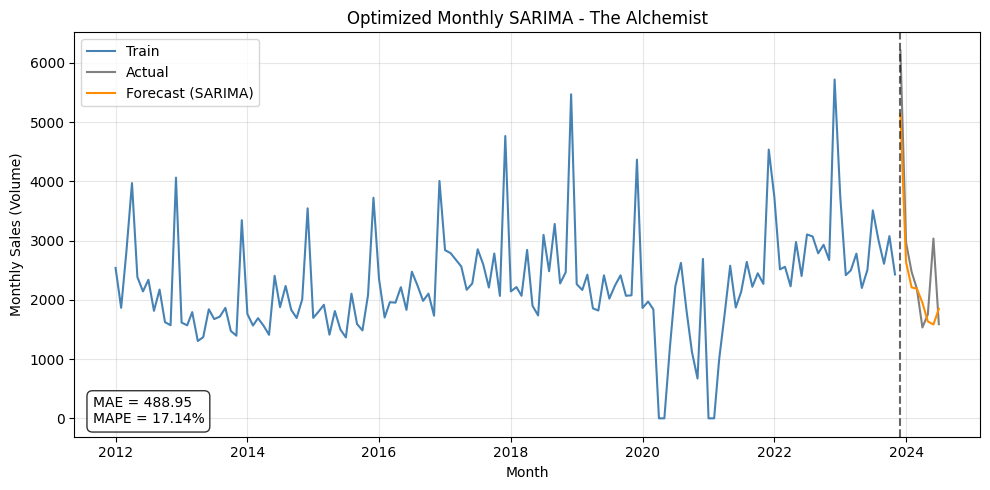


========================= SARIMA (MAE-Optimized) Monthly Model for The Very Hungry Caterpillar =========================
Tuning SARIMA hyperparameters based on MAE
Best SARIMA(1, 0, 1) × Seasonal(0, 1, 1, 12) | MAE=1804.27
→ Final Evaluation | MAE = 1804.27, MAPE = 16.17%


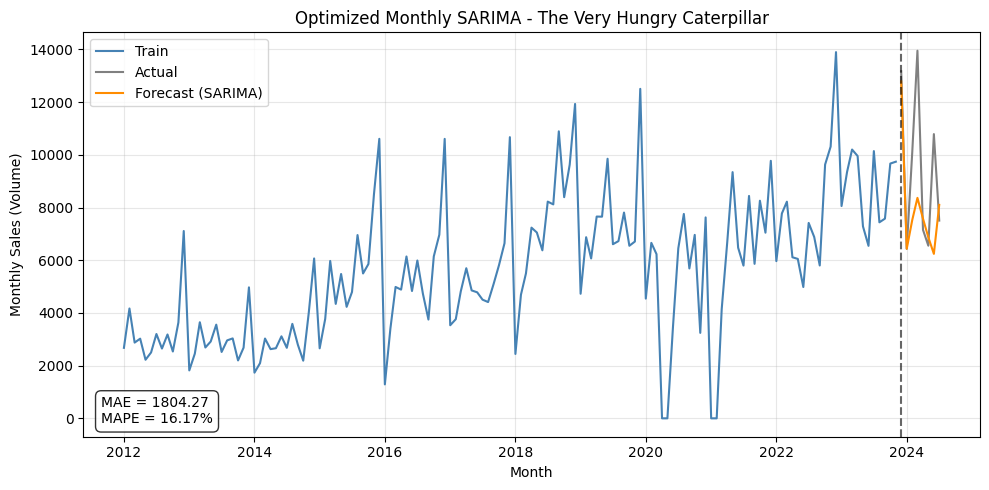

In [ ]:
for isbn, title in title_map.items():
    print(f"\n{'='*25} SARIMA (MAE-Optimized) Monthly Model for {title} {'='*25}")

    # Prepare data
    book_df = monthly_df[monthly_df['ISBN'] == isbn].set_index('Month').sort_index()
    series = book_df['Volume']

    # Train/test split
    train = series.iloc[:-forecast_horizon_months]
    test = series.iloc[-forecast_horizon_months:]

    best_mae_mSARIMA = np.inf
    best_params_mSARIMA = None
    best_model_mSARIMA = None

    print("Tuning SARIMA hyperparameters based on MAE")

    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model_mSARIMA = sm.tsa.statespace.SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results_mSARIMA = model_mSARIMA.fit(disp=False)

                # Forecast for validation period
                forecast_mSARIMA = results_mSARIMA.forecast(steps=forecast_horizon_months)
                mae_mSARIMA = mean_absolute_error(test, forecast_mSARIMA)

                # Keep model with lowest MAE
                if mae_mSARIMA < best_mae_mSARIMA:
                    best_mae_mSARIMA = mae_mSARIMA
                    best_params_mSARIMA = (order, seasonal_order)
                    best_model_mSARIMA = results_mSARIMA

            except:
                continue

    # Best model
    print(f"Best SARIMA{best_params_mSARIMA[0]} × Seasonal{best_params_mSARIMA[1]} | MAE={best_mae_mSARIMA:.2f}")

    # Forecast with best model
    forecast_mSARIMA = best_model_mSARIMA.forecast(steps=forecast_horizon_months)
    forecast_index = test.index
    forecast_series_mSARIMA = pd.Series(forecast_mSARIMA, index=forecast_index)

    # Metrics
    mae_mSARIMA = mean_absolute_error(test, forecast_series_mSARIMA)
    mape_mSARIMA = mean_absolute_percentage_error(test, forecast_series_mSARIMA) * 100

    print(f"→ Final Evaluation | MAE = {mae_mSARIMA:.2f}, MAPE = {mape_mSARIMA:.2f}%")

    # Save results
    sarima_monthly_tuned_results[title] = {
        'model': best_model_mSARIMA,
        'order': best_params_mSARIMA[0],
        'seasonal_order': best_params_mSARIMA[1],
        'train': train,
        'test': test,
        'forecast': forecast_series_mSARIMA,
        'mae': mae_mSARIMA,
        'mape': mape_mSARIMA
    }

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train', color='steelblue')
    plt.plot(test.index, test, label='Actual', color='gray')
    plt.plot(forecast_index, forecast_series_mSARIMA, label='Forecast (SARIMA)', color='darkorange')
    plt.axvline(test.index[0], color='black', linestyle='--', alpha=0.6)
    textstr = f"MAE = {mae_mSARIMA:.2f}\nMAPE = {mape_mSARIMA:.2f}%"
    plt.gca().text(0.02, 0.10, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
    plt.title(f"Optimized Monthly SARIMA - {title}")
    plt.xlabel("Month")
    plt.ylabel("Monthly Sales (Volume)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
#Summary of best SARIMA monthly models
print("\n" + "="*60)
print("SUMMARY — Best MAE-Optimized SARIMA Monthly Models")
print("="*60)

summary_rows_mSARIMA = []
for title, res in sarima_monthly_tuned_results.items():
    summary_rows_mSARIMA.append({
        'Book': title,
        'Order': res['order'],
        'Seasonal': res['seasonal_order'],
        'MAE': round(res['mae'], 2),
        'MAPE (%)': round(res['mape'], 2)
    })

summary_df_mSARIMA = pd.DataFrame(summary_rows_mSARIMA)
display(summary_df_mSARIMA)


SUMMARY — Best MAE-Optimized SARIMA Monthly Models


Book      Order       Seasonal      MAE  MAPE (%)
0                The Alchemist  (1, 2, 0)  (1, 0, 1, 12)   488.95     17.14
1  The Very Hungry Caterpillar  (1, 0, 1)  (0, 1, 1, 12)  1804.27     16.17

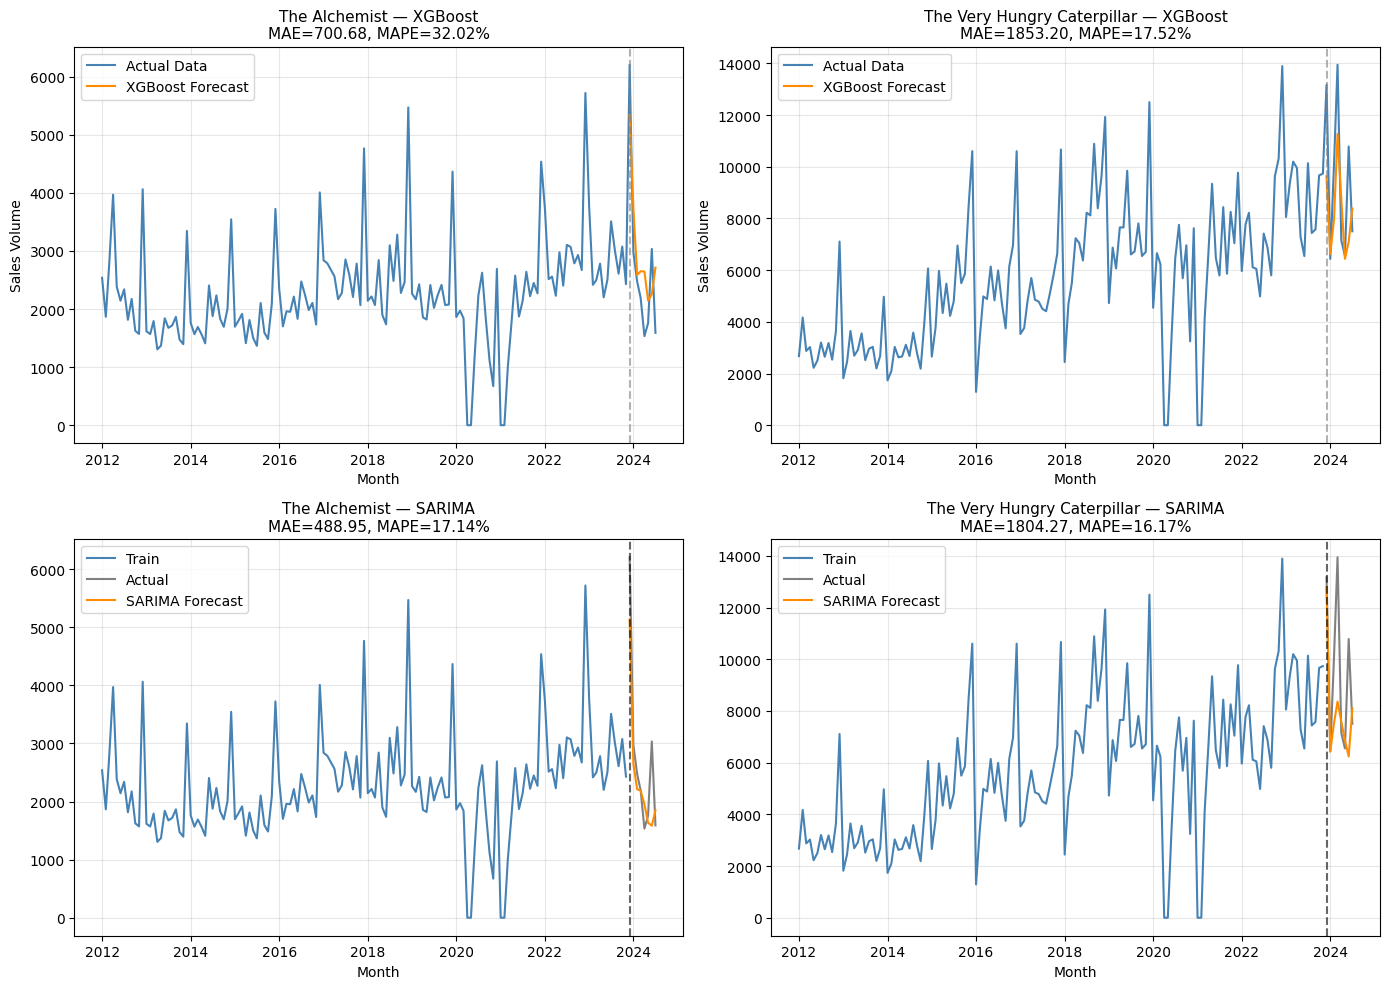

In [ ]:
#Comparing monthly results

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

books = list(title_map.values())

for i, title in enumerate(books):
    # Data
    series = monthly_df[monthly_df['Title'] == title].set_index('Month').sort_index()['Volume']

    # XGBoost results
    xgb_res = xgb_monthly_results[title]
    sarima_res = sarima_monthly_tuned_results[title]

    # Plot XGBoost
    axes[i].plot(series.index, series.values, color='steelblue', label='Actual Data')
    axes[i].plot(xgb_res['actual'].index, xgb_res['preds'], color='darkorange', label='XGBoost Forecast')
    axes[i].axvline(xgb_res['actual'].index[0], color='gray', linestyle='--', alpha=0.6)
    axes[i].set_title(f"{title} — XGBoost\nMAE={xgb_res['mae']:.2f}, MAPE={xgb_res['mape']:.2f}%", fontsize=11)
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Sales Volume")
    axes[i].grid(alpha=0.3)
    axes[i].legend()

    # Plot SARIMA in the next subplot
    if i + 2 < 4:
        ax_sarima = axes[i + 2]
        sarima_res = sarima_monthly_tuned_results[title]
        ax_sarima.plot(sarima_res['train'].index, sarima_res['train'], label='Train', color='steelblue')
        ax_sarima.plot(sarima_res['test'].index, sarima_res['test'], label='Actual', color='gray')
        ax_sarima.plot(sarima_res['forecast'].index, sarima_res['forecast'], label='SARIMA Forecast', color='darkorange')
        ax_sarima.axvline(sarima_res['test'].index[0], color='black', linestyle='--', alpha=0.6)
        ax_sarima.set_title(f"{title} — SARIMA\nMAE={sarima_res['mae']:.2f}, MAPE={sarima_res['mape']:.2f}%", fontsize=11)
        ax_sarima.set_xlabel("Month")
        ax_sarima.grid(alpha=0.3)
        ax_sarima.legend()

plt.tight_layout()
plt.show()

#Final Summary Comparison Table
summary_final = []

for title in title_map.values():
    # XGBoost
    xgb = xgb_monthly_results[title]
    summary_final.append({
        'Book': title,
        'Model': 'XGBoost',
        'MAE': round(xgb['mae'], 2),
        'MAPE (%)': round(xgb['mape'], 2),
        'Lag Window': xgb['lag_window'],
        'Order': None,
        'Seasonal': None
    })

    # SARIMA
    sarima = sarima_monthly_tuned_results[title]
    summary_final.append({
        'Book': title,
        'Model': 'SARIMA',
        'MAE': round(sarima['mae'], 2),
        'MAPE (%)': round(sarima['mape'], 2),
        'Lag Window': None,
        'Order': sarima['order'],
        'Seasonal': sarima['seasonal_order']
    })

summary_df_final = pd.DataFrame(summary_final)

#Round numeric columns to 2 decimals for display
summary_df_final['MAE'] = summary_df_final['MAE'].round(2)
summary_df_final['MAPE (%)'] = summary_df_final['MAPE (%)'].round(2)
summary_df_final['Lag Window'] = summary_df_final['Lag Window'].round(0)

#Display nicely formatted table with gradient
display(
    summary_df_final.style
        .format({'MAE': '{:.2f}', 'MAPE (%)': '{:.2f}', 'Lag Window': '{:.1f}'})
        .background_gradient(subset=['MAE', 'MAPE (%)'], cmap='Blues')
)


>When comparing the monthly forecasting performance of the two models, clear differences emerge between XGBoost and SARIMA. For The Alchemist, the SARIMA model demonstrates a notably stronger fit, with an MAE of 488.95 and a MAPE of 17.14%, compared to XGBoost’s higher error levels (MAE 700.68, MAPE 32.02%). This indicates that SARIMA is better suited to capture the seasonal and cyclical nature of the book’s sales, providing smoother and more stable predictions. XGBoost, while flexible in modeling nonlinearities, appears to overfit local fluctuations and fails to generalize the broader temporal dynamics of the series.

>For The Very Hungry Caterpillar, both models achieve relatively close performance, though SARIMA again produces slightly better accuracy (MAE 1804.27, MAPE 16.17%) compared to XGBoost (MAE 1853.20, MAPE 17.52%). This consistency reinforces SARIMA’s strength in handling structured, seasonally recurring patterns present in the data. XGBoost remains competitive, suggesting some capacity to model the non-linear variations in sales, but its forecasts exhibit slightly higher volatility.

>Overall, SARIMA emerges as the superior model for both books, offering more precise and stable monthly forecasts according to both MAE and MAPE. Its ability to account for seasonality and trend components makes it particularly effective for long-term, aggregated sales prediction tasks.